# Workbook

## Data Preprocessing

In [1]:
# import necessary packages

import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from IPython import display
import tensorflow as tf
import pandas as pd
import librosa

from sklearn.model_selection import train_test_split


# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.listdir('/content/drive/My Drive/')

# audio_path = '/content/drive/My Drive/dataset/AUDIO_NEW/'

audio_path = 'dataset/AUDIO_NEW/'

audio_types = ['breathing', 'cough', 'speech']

In [3]:
def get_directories(audio_path, audio_type):
    from pathlib import Path

    POS = os.path.join(audio_path + audio_type, 'COVID_Positive')
    NEG = os.path.join(audio_path + audio_type, 'COVID_Negative')

    # Specify the directory path
    pos_directory = Path(POS)
    neg_directory = Path(NEG)

    # List all files in the directory using iterdir()
    # pos_files = [file.name for file in pos_directory.iterdir() if file.is_file()]
    # neg_files = [file.name for file in neg_directory.iterdir() if file.is_file()]

    return pos_directory, neg_directory

In [4]:
# Load and process breathing data
pos_directory_breathing, neg_directory_breathing = get_directories(audio_path, audio_types[0])

# Load and process cough data
pos_directory_cough, neg_directory_cough = get_directories(audio_path, audio_types[1]) # audio_types[1] is 'cough'

# Load and process speech data
pos_directory_speech, neg_directory_speech = get_directories(audio_path, audio_types[2]) # audio_types[2] is 'speech'


Define custom metrics

In [5]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Custom Precision Metric for Class 1
def precision_class_1(y_true, y_pred):
    # Convert predictions to binary (0 or 1)
    y_pred_binary = K.cast(K.greater(y_pred, 0.5), dtype='float32')
    
    # True positives for class 1
    true_positives = K.sum(y_true * y_pred_binary)
    
    # Predicted positives for class 1
    predicted_positives = K.sum(y_pred_binary)
    
    # Precision calculation
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Custom Recall Metric for Class 1
def recall_class_1(y_true, y_pred):
    # Convert predictions to binary (0 or 1)
    y_pred_binary = K.cast(K.greater(y_pred, 0.5), dtype='float32')
    
    # True positives for class 1
    true_positives = K.sum(y_true * y_pred_binary)
    
    # Actual positives for class 1
    actual_positives = K.sum(y_true)
    
    # Recall calculation
    recall = true_positives / (actual_positives + K.epsilon())
    return recall

# Custom F1-Score Metric for Class 1
def f1_score_class_1(y_true, y_pred):
    precision = precision_class_1(y_true, y_pred)
    recall = recall_class_1(y_true, y_pred)
    
    # F1-score calculation
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

### Define features

In [6]:
def create_mel_spectrogram(y, sr, file_path):
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512, hop_length=128, n_mels=128)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Normalize the spectrogram
    if np.std(log_mel_spectrogram) == 0:
        print("log_mel_spectrogram == 0: ", file_path.resolve())
    
    # Normalize the spectrogram
    epsilon = 1e-6  # Small value to avoid division by zero
    log_mel_spectrogram = (log_mel_spectrogram - np.mean(log_mel_spectrogram)) / (np.std(log_mel_spectrogram) + epsilon)

    # Add channel dimension
    log_mel_spectrogram = np.expand_dims(log_mel_spectrogram, axis=-1)

    return log_mel_spectrogram

def create_zero_crossing_rate(y):
    return np.mean(librosa.feature.zero_crossing_rate(y))

def create_spectral_centroid(y, sr):
    return np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))

In [7]:
import random 

def augment_audio_random(y, sr, target_length):
    """
    Applies a random augmentation (time stretching, pitch shifting, or adding noise) to an audio signal.

    Args:
        y (numpy.ndarray): The raw audio signal.
        sr (int): Sampling rate of the audio signal.
        target_length (int): Target length for padding/truncating the audio.

    Returns:
        numpy.ndarray: Augmented audio signal padded/truncated to the target length.
    """
    # Randomly choose an augmentation type
    augmentation_type = random.choice(["time_stretch", "pitch_shift", "add_noise"])

    if augmentation_type == "time_stretch":
        # Apply time stretching with a random rate between 0.8 and 1.2
        rate = random.uniform(0.8, 1.2)
        y_augmented = librosa.effects.time_stretch(y, rate=rate)

    elif augmentation_type == "pitch_shift":
        # Apply pitch shifting with a random number of semitones between -5 and +5
        n_steps = random.randint(-5, 5)
        y_augmented = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)

    elif augmentation_type == "add_noise":
        # Add random Gaussian noise with a standard deviation of up to 0.01
        noise = np.random.normal(0, random.uniform(0.001, 0.01), y.shape)
        y_augmented = y + noise

    # Ensure the augmented audio is padded/truncated to the target length
    zero_padding = np.zeros(max(0, target_length - len(y_augmented)), dtype=np.float32)
    y_augmented_padded = np.concatenate([y_augmented[:target_length], zero_padding], axis=0)

    return y_augmented_padded

In [8]:
def augment_audio(y, sr, target_length):
    augmented_audios = []

    # Time Stretching
    augmented_audios.append(librosa.effects.time_stretch(y, rate=0.8))  # Slow down
    augmented_audios.append(librosa.effects.time_stretch(y, rate=1.2))  # Speed up

    # Pitch Shifting (use keyword arguments)
    augmented_audios.append(librosa.effects.pitch_shift(y=y, sr=sr, n_steps=2))  # Pitch up
    augmented_audios.append(librosa.effects.pitch_shift(y=y, sr=sr, n_steps=-2))  # Pitch down

    # Adding Noise
    noise = np.random.normal(0, 0.005, y.shape)
    augmented_audios.append(y + noise)

    # Ensure all augmented audios are padded/truncated to target_length
    padded_augmented_audios = []
    for aug_y in augmented_audios:
        zero_padding = np.zeros(max(0, target_length - len(aug_y)), dtype=np.float32)
        aug_y_padded = np.concatenate([aug_y[:target_length], zero_padding], axis=0)
        padded_augmented_audios.append(aug_y_padded)

    return padded_augmented_audios

### Create then split

In [9]:
def create_features(pos_directory, neg_directory, target_length, augment=False):
    print("Creating features for {0} and {1}! ".format(pos_directory, neg_directory))
    spectrograms = []
    other_features = []
    labels = []

    # Access files directly using iterdir()
    for file_path in sorted(pos_directory.iterdir()):
        y, sr = librosa.load(file_path, sr=16000)
        y = y[:target_length]
        y = librosa.util.normalize(y)

        zero_padding = np.zeros(target_length - len(y), dtype=np.float32)
        y = np.concatenate([y, zero_padding], axis=0)

        spectrograms.append(create_mel_spectrogram(y, sr, file_path))
        other_features.append([create_zero_crossing_rate(y), create_spectral_centroid(y, sr)])
        labels.append(1)


        ## Augment random
        # if augment:
        #     y_augmented = augment_audio(y, sr, target_length)
        #     spectrograms.append(create_mel_spectrogram(y_augmented, sr, file_path))
        #     other_features.append([create_zero_crossing_rate(y_augmented), create_spectral_centroid(y_augmented, sr)])
        #     labels.append(1)

        ## Augment all
        if augment:
            augmented_audios = augment_audio(y, sr, target_length)
            for aug_y in augmented_audios:
                spectrograms.append(create_mel_spectrogram(aug_y, sr, file_path))
                other_features.append([create_zero_crossing_rate(aug_y), create_spectral_centroid(aug_y, sr)])
                labels.append(1)
    
    positive_samples = len(labels)

    print(f"Number of positive samples: {positive_samples}")  

    for file_path in sorted(neg_directory.iterdir()):
        y, sr = librosa.load(file_path, sr=16000)
        y = y[:target_length]

        zero_padding = np.zeros(target_length - len(y), dtype=np.float32)
        y = np.concatenate([y, zero_padding], axis=0)

        spectrograms.append(create_mel_spectrogram(y, sr, file_path))
        other_features.append([create_zero_crossing_rate(y), create_spectral_centroid(y, sr)])
        labels.append(0)

        # if augment:
        #     y_augmented = augment_audio(y, sr, target_length)
        #     spectrograms.append(create_mel_spectrogram(y_augmented, sr, file_path))
        #     other_features.append([create_zero_crossing_rate(y_augmented), create_spectral_centroid(y_augmented, sr)])
        #     labels.append(0)

    print(f"Number of negative samples: {len(labels) - positive_samples}")           
    print("Completed creating features for {0} and {1}! ".format(pos_directory, neg_directory))

    return spectrograms, other_features, labels

In [10]:
# creating spectrogram, other features, and labels for breathing, cough, and speech

spectrograms_breathing, other_features_breathing, labels_breathing = create_features(pos_directory_breathing, neg_directory_breathing, 80000)

Creating features for dataset/AUDIO_NEW/breathing/COVID_Positive and dataset/AUDIO_NEW/breathing/COVID_Negative! 
Number of positive samples: 172
log_mel_spectrogram == 0:  /Users/opheliasin/covid-detection/dataset/AUDIO_NEW/breathing/COVID_Negative/GDOLSUHV.flac
log_mel_spectrogram == 0:  /Users/opheliasin/covid-detection/dataset/AUDIO_NEW/breathing/COVID_Negative/HTUZHMVC.flac
log_mel_spectrogram == 0:  /Users/opheliasin/covid-detection/dataset/AUDIO_NEW/breathing/COVID_Negative/TMWZXJNT.flac
Number of negative samples: 793
Completed creating features for dataset/AUDIO_NEW/breathing/COVID_Positive and dataset/AUDIO_NEW/breathing/COVID_Negative! 


In [11]:
spectrograms_cough, other_features_cough, labels_cough = create_features(pos_directory_cough, neg_directory_cough, 96000) # 6 seconds 

# 25th Percentile Duration: 4.693333333333333
# Median Duration: 6.058684807256236
# 75th Percentile Duration: 7.509319727891157

Creating features for dataset/AUDIO_NEW/cough/COVID_Positive and dataset/AUDIO_NEW/cough/COVID_Negative! 
Number of positive samples: 172
log_mel_spectrogram == 0:  /Users/opheliasin/covid-detection/dataset/AUDIO_NEW/cough/COVID_Negative/TMWZXJNT.flac
Number of negative samples: 793
Completed creating features for dataset/AUDIO_NEW/cough/COVID_Positive and dataset/AUDIO_NEW/cough/COVID_Negative! 


In [12]:
spectrograms_speech, other_features_speech, labels_speech = create_features(pos_directory_speech, neg_directory_speech, 160000) # 10 seconds

# 25th Percentile Duration: 12.458684807256235
# Median Duration: 14.421337868480725
# 75th Percentile Duration: 16.55467120181406

Creating features for dataset/AUDIO_NEW/speech/COVID_Positive and dataset/AUDIO_NEW/speech/COVID_Negative! 
Number of positive samples: 172
Number of negative samples: 793
Completed creating features for dataset/AUDIO_NEW/speech/COVID_Positive and dataset/AUDIO_NEW/speech/COVID_Negative! 


#### Create padding, combine, and create train_test_split

In [13]:
# Define a function to pad spectrograms to the maximum time frame length
def pad_spectrogram(spectrogram, max_time_frames):
    current_time_frames = spectrogram.shape[1]  # Time frames are along axis 1
    if current_time_frames < max_time_frames:
        # Calculate padding amount
        padding_amount = max_time_frames - current_time_frames
        # Pad along the time axis (axis=1)
        padded_spectrogram = np.pad(spectrogram, ((0, 0), (0, padding_amount), (0, 0)), mode='constant')
    else:
        padded_spectrogram = spectrogram
    return padded_spectrogram

In [14]:
# Maximum time frame length across all audio types
max_time_frames = 1251

# Pad all spectrograms to the maximum time frame length
padded_spectrograms_breathing = [pad_spectrogram(s, max_time_frames) for s in spectrograms_breathing]
padded_spectrograms_cough = [pad_spectrogram(s, max_time_frames) for s in spectrograms_cough]
padded_spectrograms_speech = [pad_spectrogram(s, max_time_frames) for s in spectrograms_speech]

In [15]:
# Combine spectrograms, other features, and labels for each participant
all_spectrograms = []
all_other_features = []
all_labels = []

# Assuming all lists are sorted in the same order and correspond to the same participants
for i in range(len(spectrograms_breathing)):  # Iterate over participants

    combined_spectrogram = np.concatenate(
        [padded_spectrograms_breathing[i], padded_spectrograms_cough[i], padded_spectrograms_speech[i]], axis=1
    )
    
    # Combine other features for breathing, coughing, and speech
    combined_other_features = np.concatenate(
        [other_features_breathing[i], other_features_cough[i], other_features_speech[i]], axis=0
    )
    
    # Assume labels are consistent across all audio types for a participant
    label = labels_breathing[i]  # You can use any of the label lists since they are consistent

    # Append combined data to the final lists
    all_spectrograms.append(combined_spectrogram)
    all_other_features.append(combined_other_features)
    all_labels.append(label)

# Convert to NumPy arrays
all_spectrograms = np.array(all_spectrograms)
all_other_features = np.array(all_other_features)
all_labels = np.array(all_labels)

# Flatten spectrograms and combine with other features
all_spectrograms_flattened = all_spectrograms.reshape(all_spectrograms.shape[0], -1)
X_combined = np.hstack([all_spectrograms_flattened, all_other_features])


In [16]:
# Shazia's Code
# all_spectrograms = spectrograms_cough + spectrograms_speech + spectrograms_breathing
# all_other_features = other_features_cough + other_features_speech + other_features_breathing
# all_labels = labels_cough + labels_speech + labels_breathing

# # Convert to NumPy arrays
# all_spectrograms = np.array(all_spectrograms)
# all_other_features = np.array(all_other_features)
# all_labels = np.array(all_labels)
# all_spectrograms_flattened = all_spectrograms.reshape(all_spectrograms.shape[0], -1)

In [17]:
# X_combined = np.hstack([all_spectrograms_flattened, all_other_features])

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_combined, all_labels, test_size=0.2, stratify=all_labels)

In [19]:
from collections import Counter

Counter(all_labels), Counter(y_train), Counter(y_test)

(Counter({np.int64(0): 793, np.int64(1): 172}),
 Counter({np.int64(0): 634, np.int64(1): 138}),
 Counter({np.int64(0): 159, np.int64(1): 34}))

In [ ]:
# Flatten each spectrogram into a single vector
# Resulting shape will be (num_samples, height * width * channels)
# X_train_numpy = np.array(X_train)
# X_train_flattened = X_train_numpy.reshape(X_train_numpy.shape[0], -1)

# print(f"Original shape: {X_train_numpy.shape}")
# print(f"Flattened shape: {X_train_flattened.shape}")

### Split to train-test then create features

In [9]:
import random
from pathlib import Path

def split_train_test_consistent(pos_dir, neg_dir, test_size=0.2, random_seed=42):
    """
    Splits positive and negative directories into training and testing subsets with consistent shuffling.

    Args:
        pos_dirs (List[Path]): List of directories containing positive samples (e.g., cough, breathing, speech).
        neg_dirs (List[Path]): List of directories containing negative samples (e.g., cough, breathing, speech).
        test_size (float): Proportion of files to include in the test set (default is 0.2).
        random_seed (int): Random seed for reproducibility.

    Returns:
        Tuple[Tuple[List[List[Path]], List[List[Path]]], Tuple[List[List[Path]], List[List[Path]]]]:
            - ((train_pos_files_by_type, test_pos_files_by_type), (train_neg_files_by_type, test_neg_files_by_type))
    """
    np.random.seed(random_seed)  # Set seed for reproducibility

    train_pos_files_by_type = []
    test_pos_files_by_type = []
    train_neg_files_by_type = []
    test_neg_files_by_type = []

    # Process each audio type (cough, breathing, speech)
    pos_files = sorted(list(pos_dir.iterdir()))
    neg_files = sorted(list(neg_dir.iterdir()))

    # Generate consistent shuffle indices
    pos_indices = np.random.permutation(len(pos_files))
    neg_indices = np.random.permutation(len(neg_files))

    # Split indices into train and test sets
    num_pos_test = int(len(pos_files) * test_size)
    num_neg_test = int(len(neg_files) * test_size)


    train_pos_indices = pos_indices[num_pos_test:]
    test_pos_indices = pos_indices[:num_pos_test]

    train_neg_indices = neg_indices[num_neg_test:]
    test_neg_indices = neg_indices[:num_neg_test]

    # Split files into train and test sets using the indices
    train_pos_files = [pos_files[i] for i in train_pos_indices]
    test_pos_files = [pos_files[i] for i in test_pos_indices]

    train_neg_files = [neg_files[i] for i in train_neg_indices]
    test_neg_files = [neg_files[i] for i in test_neg_indices]

    # Append results for this audio type
    return (train_pos_files, test_pos_files), (train_neg_files, test_neg_files)

In [10]:
pos_breathing_path = Path(audio_path + 'breathing/COVID_Positive')
neg_breathing_path = Path(audio_path + 'breathing/COVID_Negative')

pos_cough_path = Path(audio_path + 'cough/COVID_Positive')
neg_cough_path = Path(audio_path + 'cough/COVID_Negative')

pos_speech_path = Path(audio_path + 'speech/COVID_Positive')
neg_speech_path = Path(audio_path + 'speech/COVID_Negative')

(train_pos_breathing_files, test_pos_breathing_files), (train_neg_breathing_files, test_neg_breathing_ffiles) = split_train_test_consistent(
    pos_breathing_path,
    neg_breathing_path,
    test_size=0.2,
    random_seed=42
)

(train_pos_cough_files, test_pos_breathing_files), (train_neg_cough_files, test_neg_cough_files)= split_train_test_consistent(
    pos_cough_path,
    neg_cough_path,
    test_size=0.2,
    random_seed=42
)

(train_pos_speech_files, test_pos_speech_files), (train_neg_speech_files, test_neg_speech_files) = split_train_test_consistent(
    pos_speech_path,
    neg_speech_path,
    test_size=0.2,
    random_seed=42
)

In [ ]:
def create_features_splitted(pos_directory, neg_directory, target_length, augment=True):
    #print("Creating features for {0} and {1}! ".format(pos_directory, neg_directory))
    spectrograms = []
    other_features = []
    labels = []

    # Access files directly using iterdir()
    for file_path in sorted(pos_directory):
        y, sr = librosa.load(file_path, sr=16000)
        y = y[:target_length]
        y = librosa.util.normalize(y)

        zero_padding = np.zeros(target_length - len(y), dtype=np.float32)
        y = np.concatenate([y, zero_padding], axis=0)

        spectrograms.append(create_mel_spectrogram(y, sr, file_path))
        other_features.append([create_zero_crossing_rate(y), create_spectral_centroid(y, sr)])
        labels.append(1)


        ## Augment random
        # if augment:
        #     y_augmented = augment_audio(y, sr, target_length)
        #     spectrograms.append(create_mel_spectrogram(y_augmented, sr, file_path))
        #     other_features.append([create_zero_crossing_rate(y_augmented), create_spectral_centroid(y_augmented, sr)])
        #     labels.append(1)

        ## Augment all
        if augment:
            augmented_audios = augment_audio(y, sr, target_length)
            for aug_y in augmented_audios:
                spectrograms.append(create_mel_spectrogram(aug_y, sr, file_path))
                other_features.append([create_zero_crossing_rate(aug_y), create_spectral_centroid(aug_y, sr)])
                labels.append(1)
    
    positive_samples = len(labels)

    print(f"Number of positive samples: {positive_samples}")  

    for file_path in sorted(neg_directory):
        y, sr = librosa.load(file_path, sr=16000)
        y = y[:target_length]

        zero_padding = np.zeros(target_length - len(y), dtype=np.float32)
        y = np.concatenate([y, zero_padding], axis=0)

        spectrograms.append(create_mel_spectrogram(y, sr, file_path))
        other_features.append([create_zero_crossing_rate(y), create_spectral_centroid(y, sr)])
        labels.append(0)

        # if augment:
        #     y_augmented = augment_audio(y, sr, target_length)
        #     spectrograms.append(create_mel_spectrogram(y_augmented, sr, file_path))
        #     other_features.append([create_zero_crossing_rate(y_augmented), create_spectral_centroid(y_augmented, sr)])
        #     labels.append(0)

    print(f"Number of negative samples: {len(labels) - positive_samples}")           
    # print("Completed creating features for {0} and {1}! ".format(pos_directory, neg_directory))

    return spectrograms, other_features, labels

In [ ]:
spectrograms_breathing_train, other_features_breathing_train, labels_breathing_train  = create_features_splitted(train_pos_breathing_files, train_neg_breathing_files, 80000)
spectrograms_breathing_test, other_features_breathing_test, labels_breathing_test  = create_features_splitted(test_pos_breathing_files, test_neg_breathing_ffiles, 80000, augment=False)
spectrograms_cough_train, other_features_cough_train, labels_cough_train  =  create_features_splitted(train_pos_cough_files, train_neg_cough_files, 96000)
spectrograms_cough_test , other_features_cough_test , labels_cough_test  =  create_features_splitted(test_pos_breathing_files, test_neg_cough_files, 96000, augment=False)
spectrograms_speech_train, other_features_speech_train, labels_speech_train  =  create_features_splitted(train_pos_speech_files, train_neg_speech_files, 160000)
spectrograms_speech_test, other_features_speech_test, labels_speech_test  = create_features_splitted(test_pos_speech_files, test_neg_speech_files, 160000, augment=False)


Number of positive samples: 828
log_mel_spectrogram == 0:  /Users/opheliasin/covid-detection/dataset/AUDIO_NEW/breathing/COVID_Negative/GDOLSUHV.flac
log_mel_spectrogram == 0:  /Users/opheliasin/covid-detection/dataset/AUDIO_NEW/breathing/COVID_Negative/HTUZHMVC.flac
log_mel_spectrogram == 0:  /Users/opheliasin/covid-detection/dataset/AUDIO_NEW/breathing/COVID_Negative/TMWZXJNT.flac
Number of negative samples: 635
Completed creating features for [PosixPath('dataset/AUDIO_NEW/breathing/COVID_Positive/LWGYMJSP.flac'), PosixPath('dataset/AUDIO_NEW/breathing/COVID_Positive/RAZZZUHF.flac'), PosixPath('dataset/AUDIO_NEW/breathing/COVID_Positive/IMVMQMPG.flac'), PosixPath('dataset/AUDIO_NEW/breathing/COVID_Positive/GDWOVBBO.flac'), PosixPath('dataset/AUDIO_NEW/breathing/COVID_Positive/MEVKZFWH.flac'), PosixPath('dataset/AUDIO_NEW/breathing/COVID_Positive/JQLDLKIU.flac'), PosixPath('dataset/AUDIO_NEW/breathing/COVID_Positive/GPGASWOP.flac'), PosixPath('dataset/AUDIO_NEW/breathing/COVID_Positiv

In [ ]:
# Maximum time frame length across all audio types
# max_time_frames = 1251

# # Pad all spectrograms to the maximum time frame length
# padded_spectrograms_breathing_train = [pad_spectrogram(s, max_time_frames) for s in spectrograms_breathing_train]
# padded_spectrograms_breathing_test = [pad_spectrogram(s, max_time_frames) for s in spectrograms_breathing_test]

# padded_spectrograms_cough_train = [pad_spectrogram(s, max_time_frames) for s in spectrograms_cough_train]
# padded_spectrograms_cough_test = [pad_spectrogram(s, max_time_frames) for s in spectrograms_cough_test]

# padded_spectrograms_speech_train = [pad_spectrogram(s, max_time_frames) for s in spectrograms_speech_train]
# padded_spectrograms_speech_test = [pad_spectrogram(s, max_time_frames) for s in spectrograms_speech_test]

In [34]:
# # Combine spectrograms, other features, and labels for each participant
# all_spectrograms_train = []
all_other_features_train = []
all_labels_train = []

# all_spectrograms_test = []
all_other_features_test = []
all_labels_test = []

for i in range(len(spectrograms_breathing_train)):  # Iterate over participants

#     combined_spectrogram_train = np.concatenate(
#         [padded_spectrograms_breathing_train[i], padded_spectrograms_cough_train[i], padded_spectrograms_speech_train[i]], axis=1
#     )
    
    # Combine other features for breathing, coughing, and speech
    combined_other_features_train = np.concatenate(
        [other_features_breathing_train[i], other_features_cough_train[i], other_features_speech_train[i]], axis=0
    )
    
    # Assume labels are consistent across all audio types for a participant
    label_train = labels_breathing_train[i]  # You can use any of the label lists since they are consistent

#     # Append combined data to the final lists
#     all_spectrograms_train.append(combined_spectrogram_train)
    all_other_features_train.append(combined_other_features_train)
    all_labels_train.append(label_train)


for i in range(len(spectrograms_breathing_test)):  # Iterate over participants
    
        # combined_spectrogram_test = np.concatenate(
        #     [padded_spectrograms_breathing_test[i], padded_spectrograms_cough_test[i], padded_spectrograms_speech_test[i]], axis=1
        # )
        
        # Combine other features for breathing, coughing, and speech
        combined_other_features_test = np.concatenate(
            [other_features_breathing_test[i], other_features_cough_test[i], other_features_speech_test[i]], axis=0
        )
        
        # Assume labels are consistent across all audio types for a participant
        label_test = labels_breathing_test[i]  # You can use any of the label lists since they are consistent
    
#         # Append combined data to the final lists
#         all_spectrograms_test.append(combined_spectrogram_test)
        all_other_features_test.append(combined_other_features_test)
        all_labels_test.append(label_test)
    

# # Convert to NumPy arrays
# all_spectrograms_train = np.array(all_spectrograms_train)
all_other_features_train = np.array(all_other_features_train)
all_labels_train = np.array(all_labels_train)

# all_spectrograms_test = np.array(all_spectrograms_test)
all_other_features_test = np.array(all_other_features_test)
all_labels_test = np.array(all_labels_test)


# # Flatten spectrograms and combine with other features
# all_spectrograms_train_flattened = all_spectrograms_train.reshape(all_spectrograms_train.shape[0], -1)
# X_combined_train = np.hstack([all_spectrograms_train_flattened, all_other_features_train])

# all_spectrograms_test_flattened = all_spectrograms_test.reshape(all_spectrograms_test.shape[0], -1)
# X_combined_test = np.hstack([all_spectrograms_test_flattened, all_other_features_test])

## Training only after data augmentation

- 0.49 balanced accuracy

In [21]:
# Constants for updated time frames
num_mel_bands = 128
original_time_frames_breathing = 626 # prev: 622
original_time_frames_coughing = 751 # prev: 747
original_time_frames_speech = 1251 # prev: 1247

# Total original time frames
original_total_time_frames = original_time_frames_breathing + original_time_frames_coughing + original_time_frames_speech

# Total spectrogram features
total_padded_spectrogram_features = num_mel_bands * (max_time_frames * 3)

In [ ]:
# # Separate resampled padded spectrograms and other features for X_train_resampled
# padded_spectrograms_resampled_X_train = X_combined_train[:, :total_padded_spectrogram_features]
# other_features_resampled_X_train = X_combined_train[:, total_padded_spectrogram_features:]

# padded_spectrograms_resampled_X_test = X_combined_test[:, :total_padded_spectrogram_features]
# other_features_resampled_X_test = X_combined_test[:, total_padded_spectrogram_features:]

In [ ]:
# padded_spectrograms_resampled_reshaped = padded_spectrograms_resampled.reshape(
#     padded_spectrograms_resampled.shape[0], num_mel_bands,
#     max_time_frames * 3, 1
# )


In [ ]:
# padded_spectrograms_resampled_reshaped.shape

(1460, 128, 3753, 1)

In [ ]:
# # Define a function to extract the original spectrograms without padding
# def extract_original_spectrograms(padded_spectrograms, time_frames_breathing, time_frames_coughing, time_frames_speech):
#     # Extract breathing spectrogram
#     breathing = padded_spectrograms[:, :, :time_frames_breathing, :]
    
#     # Extract coughing spectrogram
#     coughing_start = time_frames_breathing
#     coughing_end = time_frames_breathing + time_frames_coughing
#     coughing = padded_spectrograms[:, :, coughing_start:coughing_end, :]
    
#     # Extract speech spectrogram
#     speech_start = coughing_end
#     speech_end = speech_start + time_frames_speech
#     speech = padded_spectrograms[:, :, speech_start:speech_end, :]
    
#     return breathing, coughing, speech

In [ ]:
# # Extract the original spectrograms from the padded data
# spectrograms_train_breathing, spectrograms_train_coughing, spectrograms_train_speech = extract_original_spectrograms(
#     all_spectrograms_train_flattened,
#     original_time_frames_breathing,
#     original_time_frames_coughing,
#     original_time_frames_speech
# )

In [ ]:
# # Verify the shapes of the extracted spectrograms
# print("Breathing Spectrogram Shape:", spectrograms_train_breathing.shape)  # Expected: (num_samples, 128, 622, 1)
# print("Coughing Spectrogram Shape:", spectrograms_train_coughing.shape)   # Expected: (num_samples, 128, 747, 1)
# print("Speech Spectrogram Shape:", spectrograms_train_speech.shape)       # Expected: (num_samples, 128, 1247, 1)

Breathing Spectrogram Shape: (1460, 128, 626, 1)
Coughing Spectrogram Shape: (1460, 128, 751, 1)
Speech Spectrogram Shape: (1460, 128, 1251, 1)


In [24]:
spectrograms_breathing_train = np.array(spectrograms_breathing_train)
spectrograms_breathing_test = np.array(spectrograms_breathing_test)

spectrograms_cough_train = np.array(spectrograms_cough_train)
spectrograms_cough_test = np.array(spectrograms_cough_test)

spectrograms_speech_train = np.array(spectrograms_speech_train)
spectrograms_speech_test = np.array(spectrograms_speech_test)

In [ ]:
# # For X_test (no resampling needed), separate and reshape the spectrograms
# spectrograms_test = X_test[:, :total_padded_spectrogram_features]
# other_features_test = X_test[:, total_padded_spectrogram_features:]

In [ ]:
# spectrograms_test.shape, other_features_test.shape

((365, 480384), (365, 6))

In [ ]:
# spectrograms_test_reshaped = spectrograms_test.reshape(
#     spectrograms_test.shape[0], num_mel_bands, max_time_frames * 3, 1
# )

In [ ]:
# Separate spectrogram_test_reshaped into breathing, coughing, and speech
# spectrograms_test_breathing_resampled = spectrograms_test_reshaped[:, :, :num_time_frames, :]
# spectrograms_test_coughing_resampled = spectrograms_test_reshaped[:, :, num_time_frames:num_time_frames*2, :]
# spectrograms_test_speech_resampled = spectrograms_test_reshaped[:, :, num_time_frames*2:, :]

# spectrograms_test_breathing, spectrograms_test_coughing, spectrograms_test_speech = extract_original_spectrograms(
#     spectrograms_test_reshaped,
#     original_time_frames_breathing,
#     original_time_frames_coughing,
#     original_time_frames_speech
# )
# # Verify shapes
# print("Breathing Spectrogram Shape:", spectrograms_test_breathing.shape)
# print("Coughing Spectrogram Shape:", spectrograms_test_coughing.shape)
# print("Speech Spectrogram Shape:", spectrograms_test_speech.shape)


Breathing Spectrogram Shape: (365, 128, 626, 1)
Coughing Spectrogram Shape: (365, 128, 751, 1)
Speech Spectrogram Shape: (365, 128, 1251, 1)


In [25]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Concatenate, Dropout

# Define input for Mel spectrogram (shape: 625 time frames x 128 frequency bins x 1 channel)
mel_input_breathing = Input(shape=(128, 626, 1), name='mel_spectrogram_breathing')
mel_input_cough = Input(shape=(128, 751, 1), name='mel_spectrogram_cough')
mel_input_speech = Input(shape=(128, 1251, 1), name='mel_spectrogram_speech')


# Define CNN sub-network for Mel spectrogram
def create_cnn_subnetwork(input_layer):
    x = Conv2D(16, (3,3), activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(16, (3,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(32, (3,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = GlobalAveragePooling2D()(x)

    return x

# Create CNN sub-networks for each spectrogram input
cnn_breathing_output = create_cnn_subnetwork(mel_input_breathing)
cnn_cough_output = create_cnn_subnetwork(mel_input_cough)
cnn_speech_output = create_cnn_subnetwork(mel_input_speech)

# Define input for other features (zero-crossing rate and spectral centroid)
other_input = Input(shape=(6,), name='other_features')

# Define a simple dense sub-network for other features
y = Dense(64, activation='relu')(other_input)
y = Dense(128, activation='relu')(y)  # Add more dense layers
y = Dropout(0.3)(y)                   # Add dropout to prevent overfitting
y = Dense(128, activation='relu')(y)   # Another dense layer
y = Dense(64, activation='relu')(y)    # Another dense layer

# Concatenate both sub-networks
combined = Concatenate()([cnn_breathing_output, cnn_cough_output, cnn_speech_output, y])

# Add final classification layers
z = Dense(128, activation='relu')(combined)
z = Dropout(0.3)(z)                    # Add dropout to prevent overfitting
z = Dense(64, activation='relu')(z)
z = Dense(1, activation='sigmoid')(z)  # Binary classification

In [26]:
# Define the model with two inputs
model = tf.keras.Model(inputs=[mel_input_breathing, mel_input_cough, mel_input_speech, other_input], outputs=z)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','recall','precision'])

# Print model summary
# model.summary()

In [39]:
y_train = np.array(labels_breathing_train)

In [40]:
X_train_breathing, X_val_breathing, \
X_train_coughing, X_val_coughing, \
X_train_speech, X_val_speech, \
X_train_other_features, X_val_other_features, \
y_train, y_val = train_test_split(
    spectrograms_breathing_train,
    spectrograms_cough_train,
    spectrograms_speech_train,
    all_other_features_train,
    y_train,
    test_size=0.2,
    random_state=seed,
    stratify=y_train
)

# Step 2: Verify shapes of training and validation sets
print("Training set shapes:")
print("Breathing:", X_train_breathing.shape)
print("Coughing:", X_train_coughing.shape)
print("Speech:", X_train_speech.shape)
print("Other Features:", X_train_other_features.shape)
print("Labels:", y_train.shape)

print("\nValidation set shapes:")
print("Breathing:", X_val_breathing.shape)
print("Coughing:", X_val_coughing.shape)
print("Speech:", X_val_speech.shape)
print("Other Features:", X_val_other_features.shape)
print("Labels:", y_val.shape)


Training set shapes:
Breathing: (1170, 128, 626, 1)
Coughing: (1170, 128, 751, 1)
Speech: (1170, 128, 1251, 1)
Other Features: (1170, 6)
Labels: (1170,)

Validation set shapes:
Breathing: (293, 128, 626, 1)
Coughing: (293, 128, 751, 1)
Speech: (293, 128, 1251, 1)
Other Features: (293, 6)
Labels: (293,)


In [66]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Metric to monitor (e.g., validation loss)
    patience=5,                 # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore the weights of the best epoch
    verbose=1                   # Print messages when early stopping is triggered
)


# Compute class weights
class_weights = {0: 1.0, 1: 2.0} 

In [69]:
history = model.fit(
    [X_train_breathing, X_train_coughing, X_train_speech, X_train_other_features],
    y_train,
    validation_data=(
        [X_val_breathing, X_val_coughing, X_val_speech, X_val_other_features],
        y_val
    ),
    epochs=20,
    batch_size=32,
    class_weight = class_weights,
    callbacks=[early_stopping]
)


# Step 4: Evaluate the model on the validation set
results = model.evaluate(
    [X_val_breathing, X_val_coughing, X_val_speech, X_val_other_features],
    y_val
)

Epoch 1/20


/Users/opheliasin/covid-detection/venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['mel_spectrogram_breathing', 'mel_spectrogram_cough', 'mel_spectrogram_speech', 'other_features']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


37/37 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8322 - loss: 0.5209 - precision: 0.8473 - recall: 0.8473 - val_accuracy: 0.8976 - val_loss: 0.3842 - val_precision: 0.9304 - val_recall: 0.8855
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.8283 - loss: 0.5419 - precision: 0.8429 - recall: 0.8456 - val_accuracy: 0.9044 - val_loss: 0.3355 - val_precision: 0.9539 - val_recall: 0.8735
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.8424 - loss: 0.5110 - precision: 0.8578 - recall: 0.8555 - val_accuracy: 0.8771 - val_loss: 0.3852 - val_precision: 0.8963 - val_recall: 0.8855
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.8391 - loss: 0.5093 - precision: 0.8554 - recall: 0.8516 - val_accuracy: 0.9010 - val_loss: 0.3365 - val_precision: 0.9419 - val_recall: 0.8795
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.8575 - loss: 0.5037 - precision: 0.8858 - recall: 0.8508 - val_accuracy: 0.9044 - val_loss: 0.3647 - val_precision:

In [77]:
y_pred_train = model.predict([spectrograms_breathing_train, spectrograms_cough_train, spectrograms_speech_train, all_other_features_train])

46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 358ms/step


In [78]:
y_pred_train_binary = (y_pred_train > 0.6).astype(int)

In [82]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

balanced_acc = balanced_accuracy_score(all_labels_train, y_pred_train_binary)
print(f"Balanced Accuracy: {balanced_acc}")

accuracy_train = accuracy_score(all_labels_train, y_pred_train_binary)

print(f"Training Accuracy: {accuracy_train}")

Balanced Accuracy: 0.8908126973258778
Training Accuracy: 0.8824333561175667


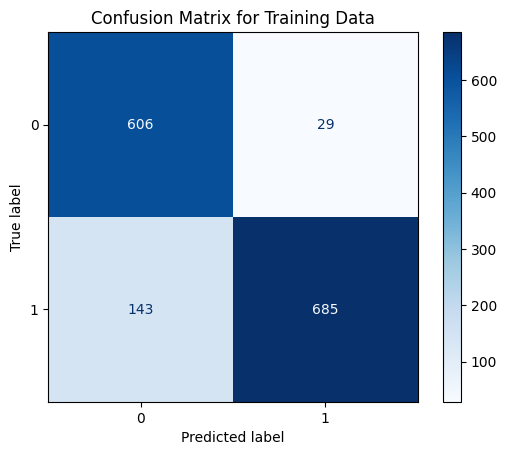

In [80]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels_train, y_pred_train_binary)

# Step 4: Visualize or print the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Training Data")
plt.show()

#### Test

In [84]:
y_pred_test = model.predict([spectrograms_breathing_test, spectrograms_cough_test, spectrograms_speech_test, all_other_features_test])
y_pred_test_binary = (y_pred_test > 0.6).astype(int)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 366ms/step


In [85]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

balanced_acc = balanced_accuracy_score(all_labels_test, y_pred_test_binary)
print(f"Balanced Accuracy: {balanced_acc}")

accuracy_train = accuracy_score(all_labels_test, y_pred_test_binary)

print(f"Training Accuracy: {accuracy_train}")

Balanced Accuracy: 0.5020476545048399
Training Accuracy: 0.8072916666666666


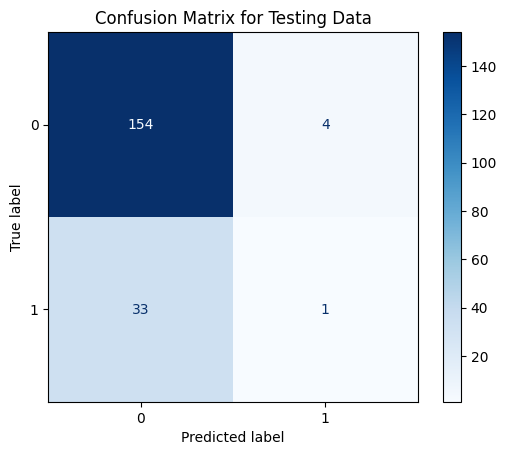

In [89]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_labels_test, y_pred_test_binary)

# Step 4: Visualize or print the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Testing Data")
plt.show()

In [90]:
from sklearn.metrics import classification_report

print(classification_report(all_labels_test, y_pred_test_binary))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89       158
           1       0.20      0.03      0.05        34

    accuracy                           0.81       192
   macro avg       0.51      0.50      0.47       192
weighted avg       0.71      0.81      0.74       192



## SMOTEENN

- training balanced accuracy: `0.6131474932390264`
- testing balanced accuracy: `0.4841842397336293`

We used the `SMOTEENN` function in the imblearn library to handle imbalanced datasets by oversampling `1`, the minority class and remove noisy samples. 

In [29]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from collections import Counter


# smote = SMOTE(sampling_strategy=0.5)  # Oversample minority class to 50% of majority class
enn = EditedNearestNeighbours(n_neighbors=5, kind_sel="mode") 
# smote_enn = SMOTEENN(smote=smote, enn=enn, random_state=seed)

# smote_enn = SMOTEENN(random_state=seed, sampling_strategy={0: 634, 1: 300})

smote_enn = SMOTEENN(random_state=seed, sampling_strategy='minority', enn=enn)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

In [30]:
# Print resampled class distribution
print(f"Original class distribution: {Counter(y_train)}")
print(f"Resampled class distribution: {Counter(y_train_resampled)}")

Original class distribution: Counter({np.int64(0): 634, np.int64(1): 138})
Resampled class distribution: Counter({np.int64(0): 634, np.int64(1): 632})


In [ ]:
# # Reshape back to original format after resampling
# X_resampled = X_resampled.reshape(X_resampled.shape[0], 128, 626, 1)

# print(f"Reshaped back to original format: {X_resampled.shape}")

In [31]:
# Constants for updated time frames
num_mel_bands = 128
original_time_frames_breathing = 626 # prev: 622
original_time_frames_coughing = 751 # prev: 747
original_time_frames_speech = 1251 # prev: 1247

# Total original time frames
original_total_time_frames = original_time_frames_breathing + original_time_frames_coughing + original_time_frames_speech

# Total spectrogram features
total_padded_spectrogram_features = num_mel_bands * (max_time_frames * 3)

In [32]:
# Separate resampled padded spectrograms and other features for X_train_resampled
padded_spectrograms_resampled = X_train_resampled[:, :total_padded_spectrogram_features]
other_features_resampled = X_train_resampled[:, total_padded_spectrogram_features:]

In [33]:
padded_spectrograms_resampled.shape, other_features_resampled.shape

((1266, 480384), (1266, 6))

In [34]:
padded_spectrograms_resampled_reshaped = padded_spectrograms_resampled.reshape(
    padded_spectrograms_resampled.shape[0], num_mel_bands,
    max_time_frames * 3, 1
)


In [35]:
padded_spectrograms_resampled_reshaped.shape

(1266, 128, 3753, 1)

In [36]:
# Define a function to extract the original spectrograms without padding
def extract_original_spectrograms(padded_spectrograms, time_frames_breathing, time_frames_coughing, time_frames_speech):
    # Extract breathing spectrogram
    breathing = padded_spectrograms[:, :, :time_frames_breathing, :]
    
    # Extract coughing spectrogram
    coughing_start = time_frames_breathing
    coughing_end = time_frames_breathing + time_frames_coughing
    coughing = padded_spectrograms[:, :, coughing_start:coughing_end, :]
    
    # Extract speech spectrogram
    speech_start = coughing_end
    speech_end = speech_start + time_frames_speech
    speech = padded_spectrograms[:, :, speech_start:speech_end, :]
    
    return breathing, coughing, speech

# Extract the original spectrograms from the padded data
spectrograms_train_breathing, spectrograms_train_coughing, spectrograms_train_speech = extract_original_spectrograms(
    padded_spectrograms_resampled_reshaped,
    original_time_frames_breathing,
    original_time_frames_coughing,
    original_time_frames_speech
)

In [37]:
# Verify the shapes of the extracted spectrograms
print("Breathing Spectrogram Shape:", spectrograms_train_breathing.shape)  # Expected: (num_samples, 128, 622, 1)
print("Coughing Spectrogram Shape:", spectrograms_train_coughing.shape)   # Expected: (num_samples, 128, 747, 1)
print("Speech Spectrogram Shape:", spectrograms_train_speech.shape)       # Expected: (num_samples, 128, 1247, 1)

Breathing Spectrogram Shape: (1266, 128, 626, 1)
Coughing Spectrogram Shape: (1266, 128, 751, 1)
Speech Spectrogram Shape: (1266, 128, 1251, 1)


### Process X_test

In [38]:
# For X_test (no resampling needed), separate and reshape the spectrograms
spectrograms_test = X_test[:, :total_padded_spectrogram_features]
other_features_test = X_test[:, total_padded_spectrogram_features:]

In [39]:
spectrograms_test.shape, other_features_test.shape

((193, 480384), (193, 6))

In [40]:
spectrograms_test_reshaped = spectrograms_test.reshape(
    spectrograms_test.shape[0], num_mel_bands, max_time_frames * 3, 1
)

In [41]:
# Separate spectrogram_test_reshaped into breathing, coughing, and speech
# spectrograms_test_breathing_resampled = spectrograms_test_reshaped[:, :, :num_time_frames, :]
# spectrograms_test_coughing_resampled = spectrograms_test_reshaped[:, :, num_time_frames:num_time_frames*2, :]
# spectrograms_test_speech_resampled = spectrograms_test_reshaped[:, :, num_time_frames*2:, :]

spectrograms_test_breathing, spectrograms_test_coughing, spectrograms_test_speech = extract_original_spectrograms(
    spectrograms_test_reshaped,
    original_time_frames_breathing,
    original_time_frames_coughing,
    original_time_frames_speech
)
# Verify shapes
print("Breathing Spectrogram Shape:", spectrograms_test_breathing.shape)
print("Coughing Spectrogram Shape:", spectrograms_test_coughing.shape)
print("Speech Spectrogram Shape:", spectrograms_test_speech.shape)


Breathing Spectrogram Shape: (193, 128, 626, 1)
Coughing Spectrogram Shape: (193, 128, 751, 1)
Speech Spectrogram Shape: (193, 128, 1251, 1)


In [42]:
#convert y_train_resampled and y_test to numpy arrays

y_train_resampled = np.array(y_train_resampled)
y_test = np.array(y_test)

### Multi-input model

In [43]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Concatenate, Dropout

# Define input for Mel spectrogram (shape: 625 time frames x 128 frequency bins x 1 channel)
mel_input_breathing = Input(shape=(128, 626, 1), name='mel_spectrogram_breathing')
mel_input_cough = Input(shape=(128, 751, 1), name='mel_spectrogram_cough')
mel_input_speech = Input(shape=(128, 1251, 1), name='mel_spectrogram_speech')


# Define CNN sub-network for Mel spectrogram
def create_cnn_subnetwork(input_layer):
    x = Conv2D(16, (3,3), activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(16, (3,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(32, (3,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = GlobalAveragePooling2D()(x)

    return x

# Create CNN sub-networks for each spectrogram input
cnn_breathing_output = create_cnn_subnetwork(mel_input_breathing)
cnn_cough_output = create_cnn_subnetwork(mel_input_cough)
cnn_speech_output = create_cnn_subnetwork(mel_input_speech)

# Define input for other features (zero-crossing rate and spectral centroid)
other_input = Input(shape=(6,), name='other_features')

# Define a simple dense sub-network for other features
y = Dense(64, activation='relu')(other_input)
y = Dense(128, activation='relu')(y)  # Add more dense layers
y = Dropout(0.3)(y)                   # Add dropout to prevent overfitting
y = Dense(128, activation='relu')(y)   # Another dense layer
y = Dense(64, activation='relu')(y)    # Another dense layer

# Concatenate both sub-networks
combined = Concatenate()([cnn_breathing_output, cnn_cough_output, cnn_speech_output, y])

# Add final classification layers
z = Dense(128, activation='relu')(combined)
z = Dropout(0.3)(z)                    # Add dropout to prevent overfitting
z = Dense(64, activation='relu')(z)
z = Dense(1, activation='sigmoid')(z)  # Binary classification

In [44]:
# Define the model with two inputs
model = tf.keras.Model(inputs=[mel_input_breathing, mel_input_cough, mel_input_speech, other_input], outputs=z)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','recall','precision'])

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mel_spectrogram_br… │ (None, 128, 626,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mel_spectrogram_co… │ (None, 128, 751,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mel_spectrogram_sp… │ (None, 128, 1251, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 624,  │        160 │ mel_spectrogram_… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 126, 749,  │        160 │ mel_spectrogram_… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 126, 1249, │        160 │ mel_spectrogram_… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 312,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 63, 374,   │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 63, 624,   │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 310,   │      2,320 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 61, 372,   │      2,320 │ max_pooling2d_4[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 61, 622,   │      2,320 │ max_pooling2d_8[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 155,   │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 30, 186,   │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 30, 311,   │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ other_features      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 153,   │      4,640 │ max_pooling2d_1[

 Total params: 151,601 (592.19 KB)

 Trainable params: 151,601 (592.19 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
y_train_resampled.shape

(1266,)

In [46]:
X_train_breathing, X_val_breathing, \
X_train_coughing, X_val_coughing, \
X_train_speech, X_val_speech, \
X_train_other_features, X_val_other_features, \
y_train, y_val = train_test_split(
    spectrograms_train_breathing,
    spectrograms_train_coughing,
    spectrograms_train_speech,
    other_features_resampled,
    y_train_resampled,
    test_size=0.2,
    random_state=seed,
    stratify=y_train_resampled
)

# Step 2: Verify shapes of training and validation sets
print("Training set shapes:")
print("Breathing:", X_train_breathing.shape)
print("Coughing:", X_train_coughing.shape)
print("Speech:", X_train_speech.shape)
print("Other Features:", X_train_other_features.shape)
print("Labels:", y_train.shape)

print("\nValidation set shapes:")
print("Breathing:", X_val_breathing.shape)
print("Coughing:", X_val_coughing.shape)
print("Speech:", X_val_speech.shape)
print("Other Features:", X_val_other_features.shape)
print("Labels:", y_val.shape)


Training set shapes:
Breathing: (1012, 128, 626, 1)
Coughing: (1012, 128, 751, 1)
Speech: (1012, 128, 1251, 1)
Other Features: (1012, 6)
Labels: (1012,)

Validation set shapes:
Breathing: (254, 128, 626, 1)
Coughing: (254, 128, 751, 1)
Speech: (254, 128, 1251, 1)
Other Features: (254, 6)
Labels: (254,)


In [47]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Metric to monitor (e.g., validation loss)
    patience=5,                 # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore the weights of the best epoch
    verbose=1                   # Print messages when early stopping is triggered
)

history = model.fit(
    [X_train_breathing, X_train_coughing, X_train_speech, X_train_other_features],
    y_train,
    validation_data=(
        [X_val_breathing, X_val_coughing, X_val_speech, X_val_other_features],
        y_val
    ),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)


# Step 4: Evaluate the model on the validation set
results = model.evaluate(
    [X_val_breathing, X_val_coughing, X_val_speech, X_val_other_features],
    y_val
)

Epoch 1/50


/Users/opheliasin/covid-detection/venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['mel_spectrogram_breathing', 'mel_spectrogram_cough', 'mel_spectrogram_speech', 'other_features']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.4883 - loss: 19.2814 - precision: 0.4808 - recall: 0.4641 - val_accuracy: 0.5079 - val_loss: 5.3011 - val_precision: 0.5040 - val_recall: 1.0000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5101 - loss: 4.2630 - precision: 0.5035 - recall: 0.5557 - val_accuracy: 0.5118 - val_loss: 0.8206 - val_precision: 0.5064 - val_recall: 0.9370
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.5101 - loss: 2.0978 - precision: 0.5022 - recall: 0.5754 - val_accuracy: 0.5551 - val_loss: 0.6859 - val_precision: 0.6250 - val_recall: 0.2756
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.5242 - loss: 0.9527 - precision: 0.5155 - recall: 0.5305 - val_accuracy: 0.5118 - val_loss: 0.6918 - val_precision: 0.6667 - val_recall: 0.0472
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.5309 - loss: 0.7536 - precision: 0.5250 - recall: 0.5066 - val_accuracy: 0.5827 - val_loss: 0.6830 - val_precision

In [ ]:
# recall = TP / TP + FN 

In [48]:
y_pred_train = model.predict([X_train_breathing, X_train_coughing, X_train_speech, X_train_other_features])

32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 453ms/step


In [49]:
y_pred_train_binary = (y_pred_train > 0.6).astype(int)

In [50]:
y_train.shape, y_pred_train_binary.shape

((1012,), (1012, 1))

In [51]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train_binary)

print(f"Training Accuracy: {accuracy_train}")

Training Accuracy: 0.8596837944664032


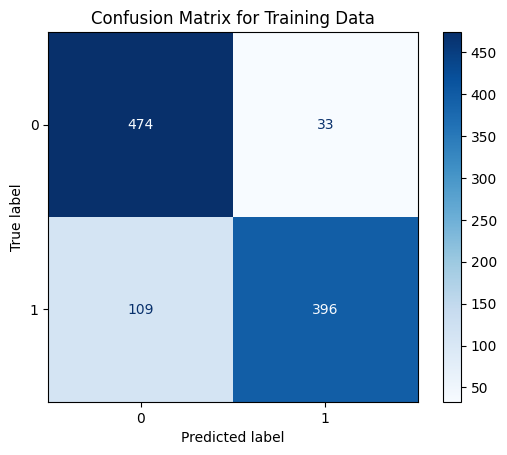

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_train, y_pred_train_binary)

# Step 4: Visualize or print the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Training Data")
plt.show()

In [54]:
from sklearn.metrics import balanced_accuracy_score

# Calculate balanced accuracy
balanced_acc = balanced_accuracy_score(y_train, y_pred_train_binary)
print(f"Balanced Accuracy: {balanced_acc}")

Balanced Accuracy: 0.8595348292225673


In [55]:
y_pred_test = model.predict([spectrograms_test_breathing, spectrograms_test_coughing, spectrograms_test_speech, other_features_test])

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step


In [56]:
y_pred_test_binary = (y_pred_test > 0.6).astype(int)

In [57]:
cm = confusion_matrix(y_test, y_pred_test_binary)

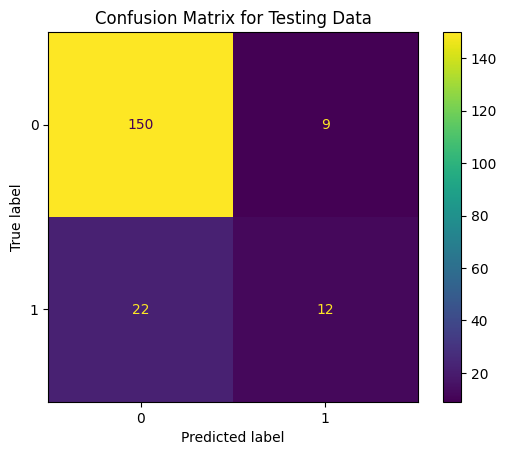

In [58]:
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.title("Confusion Matrix for Testing Data")
plt.show()

In [59]:
balanced_acc = balanced_accuracy_score(y_test, y_pred_test_binary)
print(f"Balanced Accuracy: {balanced_acc}")

Balanced Accuracy: 0.6481687014428413


## SMOTE

sampling_strategy = {1:300} -> Counter({np.int64(0): 634, np.int64(1): 300})

regular SMOTE -> Resampled class distribution: Counter({np.int64(0): 634, np.int64(1): 634})

In [57]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# smote = SMOTE(random_state=seed)
#smote = SMOTE(random_state=seed, sampling_strategy={1: 300})
smote = SMOTE(sampling_strategy=0.5, random_state=seed)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [22]:
# smote = SMOTE(sampling_strategy=0.5, random_state=seed)
# X_train_resampled_1, y_train_resampled_1 = smote.fit_resample(X_train, y_train)

In [58]:
# Print resampled class distribution
print(f"Original class distribution: {Counter(y_train)}")
print(f"Resampled class distribution: {Counter(y_train_resampled)}")
#print(f"Resampled class distribution: {Counter(y_train_resampled_1)}")

Original class distribution: Counter({np.int64(0): 634, np.int64(1): 275})
Resampled class distribution: Counter({np.int64(0): 634, np.int64(1): 317})


In [24]:
# Constants for updated time frames
num_mel_bands = 128
original_time_frames_breathing = 626 # prev: 622
original_time_frames_coughing = 751 # prev: 747
original_time_frames_speech = 1251 # prev: 1247

# Total original time frames
original_total_time_frames = original_time_frames_breathing + original_time_frames_coughing + original_time_frames_speech

# Total spectrogram features
total_padded_spectrogram_features = num_mel_bands * (max_time_frames * 3)

In [25]:
# Separate resampled padded spectrograms and other features for X_train_resampled
padded_spectrograms_resampled = X_train_resampled[:, :total_padded_spectrogram_features]
other_features_resampled = X_train_resampled[:, total_padded_spectrogram_features:]

In [26]:
padded_spectrograms_resampled.shape, other_features_resampled.shape

((951, 480384), (951, 6))

In [27]:
# Verify actual size
print("Actual size of padded_spectrograms_resampled:", padded_spectrograms_resampled.size)

# Calculate expected size
expected_size = 716 * 128 * (max_time_frames * 3) * 1
print("Expected size for reshaping:", expected_size)

Actual size of padded_spectrograms_resampled: 456845184
Expected size for reshaping: 343954944


In [28]:
padded_spectrograms_resampled_reshaped = padded_spectrograms_resampled.reshape(
    padded_spectrograms_resampled.shape[0], num_mel_bands,
    max_time_frames * 3, 1
)

In [29]:
# Define a function to extract the original spectrograms without padding
def extract_original_spectrograms(padded_spectrograms, time_frames_breathing, time_frames_coughing, time_frames_speech):
    # Extract breathing spectrogram
    breathing = padded_spectrograms[:, :, :time_frames_breathing, :]
    
    # Extract coughing spectrogram
    coughing_start = time_frames_breathing
    coughing_end = time_frames_breathing + time_frames_coughing
    coughing = padded_spectrograms[:, :, coughing_start:coughing_end, :]
    
    # Extract speech spectrogram
    speech_start = coughing_end
    speech_end = speech_start + time_frames_speech
    speech = padded_spectrograms[:, :, speech_start:speech_end, :]
    
    return breathing, coughing, speech

# Extract the original spectrograms from the padded data
spectrograms_train_breathing, spectrograms_train_coughing, spectrograms_train_speech = extract_original_spectrograms(
    padded_spectrograms_resampled_reshaped,
    original_time_frames_breathing,
    original_time_frames_coughing,
    original_time_frames_speech
)

In [30]:
# Verify the shapes of the extracted spectrograms
print("Breathing Spectrogram Shape:", spectrograms_train_breathing.shape)  # Expected: (num_samples, 128, 622, 1)
print("Coughing Spectrogram Shape:", spectrograms_train_coughing.shape)   # Expected: (num_samples, 128, 747, 1)
print("Speech Spectrogram Shape:", spectrograms_train_speech.shape)       # Expected: (num_samples, 128, 1247, 1)

Breathing Spectrogram Shape: (951, 128, 626, 1)
Coughing Spectrogram Shape: (951, 128, 751, 1)
Speech Spectrogram Shape: (951, 128, 1251, 1)


In [31]:
# For X_test (no resampling needed), separate and reshape the spectrograms
spectrograms_test = X_test[:, :total_padded_spectrogram_features]
other_features_test = X_test[:, total_padded_spectrogram_features:]

In [32]:
spectrograms_test.shape, other_features_test.shape

((228, 480384), (228, 6))

In [33]:
spectrograms_test_reshaped = spectrograms_test.reshape(
    spectrograms_test.shape[0], num_mel_bands, max_time_frames * 3, 1
)

In [34]:
spectrograms_test_breathing, spectrograms_test_coughing, spectrograms_test_speech = extract_original_spectrograms(
    spectrograms_test_reshaped,
    original_time_frames_breathing,
    original_time_frames_coughing,
    original_time_frames_speech
)
# Verify shapes
print("Breathing Spectrogram Shape:", spectrograms_test_breathing.shape)
print("Coughing Spectrogram Shape:", spectrograms_test_coughing.shape)
print("Speech Spectrogram Shape:", spectrograms_test_speech.shape)


Breathing Spectrogram Shape: (228, 128, 626, 1)
Coughing Spectrogram Shape: (228, 128, 751, 1)
Speech Spectrogram Shape: (228, 128, 1251, 1)


In [35]:
#convert y_train_resampled and y_test to numpy arrays

y_train_resampled = np.array(y_train_resampled)
y_test = np.array(y_test)

In [36]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Concatenate, Dropout

# Define input for Mel spectrogram (shape: 625 time frames x 128 frequency bins x 1 channel)
mel_input_breathing = Input(shape=(128, 626, 1), name='mel_spectrogram_breathing')
mel_input_cough = Input(shape=(128, 751, 1), name='mel_spectrogram_cough')
mel_input_speech = Input(shape=(128, 1251, 1), name='mel_spectrogram_speech')


# Define CNN sub-network for Mel spectrogram
def create_cnn_subnetwork(input_layer):
    x = Conv2D(16, (3,3), activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(16, (3,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(32, (3,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = GlobalAveragePooling2D()(x)

    return x

# Create CNN sub-networks for each spectrogram input
cnn_breathing_output = create_cnn_subnetwork(mel_input_breathing)
cnn_cough_output = create_cnn_subnetwork(mel_input_cough)
cnn_speech_output = create_cnn_subnetwork(mel_input_speech)

# Define input for other features (zero-crossing rate and spectral centroid)
other_input = Input(shape=(6,), name='other_features')

# Define a simple dense sub-network for other features
y = Dense(64, activation='relu')(other_input)
y = Dense(128, activation='relu')(y)  # Add more dense layers
y = Dropout(0.3)(y)                   # Add dropout to prevent overfitting
y = Dense(128, activation='relu')(y)   # Another dense layer
y = Dense(64, activation='relu')(y)    # Another dense layer

# Concatenate both sub-networks
combined = Concatenate()([cnn_breathing_output, cnn_cough_output, cnn_speech_output, y])

# Add final classification layers
z = Dense(128, activation='relu')(combined)
z = Dropout(0.3)(z)                    # Add dropout to prevent overfitting
z = Dense(64, activation='relu')(z)
z = Dense(1, activation='sigmoid')(z)  # Binary classification

In [37]:
# Define the model with two inputs
model = tf.keras.Model(inputs=[mel_input_breathing, mel_input_cough, mel_input_speech, other_input], outputs=z)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','recall','precision'])

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mel_spectrogram_br… │ (None, 128, 626,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mel_spectrogram_co… │ (None, 128, 751,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mel_spectrogram_sp… │ (None, 128, 1251, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 624,  │        160 │ mel_spectrogram_… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 126, 749,  │        160 │ mel_spectrogram_… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 126, 1249, │        160 │ mel_spectrogram_… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 312,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 63, 374,   │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 63, 624,   │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 310,   │      2,320 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 61, 372,   │      2,320 │ max_pooling2d_4[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 61, 622,   │      2,320 │ max_pooling2d_8[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 155,   │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 30, 186,   │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 30, 311,   │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ other_features      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 153,   │      4,640 │ max_pooling2d_1[

 Total params: 151,601 (592.19 KB)

 Trainable params: 151,601 (592.19 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
X_train_breathing, X_val_breathing, \
X_train_coughing, X_val_coughing, \
X_train_speech, X_val_speech, \
X_train_other_features, X_val_other_features, \
y_train, y_val = train_test_split(
    spectrograms_train_breathing,
    spectrograms_train_coughing,
    spectrograms_train_speech,
    other_features_resampled,
    y_train_resampled,
    test_size=0.2,
    random_state=seed,
    stratify=y_train_resampled
)

# Step 2: Verify shapes of training and validation sets
print("Training set shapes:")
print("Breathing:", X_train_breathing.shape)
print("Coughing:", X_train_coughing.shape)
print("Speech:", X_train_speech.shape)
print("Other Features:", X_train_other_features.shape)
print("Labels:", y_train.shape)

print("\nValidation set shapes:")
print("Breathing:", X_val_breathing.shape)
print("Coughing:", X_val_coughing.shape)
print("Speech:", X_val_speech.shape)
print("Other Features:", X_val_other_features.shape)
print("Labels:", y_val.shape)


Training set shapes:
Breathing: (760, 128, 626, 1)
Coughing: (760, 128, 751, 1)
Speech: (760, 128, 1251, 1)
Other Features: (760, 6)
Labels: (760,)

Validation set shapes:
Breathing: (191, 128, 626, 1)
Coughing: (191, 128, 751, 1)
Speech: (191, 128, 1251, 1)
Other Features: (191, 6)
Labels: (191,)


In [39]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Metric to monitor (e.g., validation loss)
    patience=5,                 # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore the weights of the best epoch
    verbose=1                   # Print messages when early stopping is triggered
)

history = model.fit(
    [X_train_breathing, X_train_coughing, X_train_speech, X_train_other_features],
    y_train,
    validation_data=(
        [X_val_breathing, X_val_coughing, X_val_speech, X_val_other_features],
        y_val
    ),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)


# Step 4: Evaluate the model on the validation set
results = model.evaluate(
    [X_val_breathing, X_val_coughing, X_val_speech, X_val_other_features],
    y_val
)

Epoch 1/20


/Users/opheliasin/covid-detection/venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['mel_spectrogram_breathing', 'mel_spectrogram_cough', 'mel_spectrogram_speech', 'other_features']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5649 - loss: 14.4194 - precision: 0.3417 - recall: 0.3599 - val_accuracy: 0.3298 - val_loss: 2.9478 - val_precision: 0.3298 - val_recall: 0.9688
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5164 - loss: 4.9246 - precision: 0.2776 - recall: 0.2960 - val_accuracy: 0.6649 - val_loss: 1.0493 - val_precision: 0.5000 - val_recall: 0.0469
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.5354 - loss: 2.1964 - precision: 0.2992 - recall: 0.3206 - val_accuracy: 0.3508 - val_loss: 0.8354 - val_precision: 0.3333 - val_recall: 0.9375
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5152 - loss: 1.5188 - precision: 0.2978 - recall: 0.3565 - val_accuracy: 0.5340 - val_loss: 0.8320 - val_precision: 0.2642 - val_recall: 0.2188
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5847 - loss: 1.0480 - precision: 0.3579 - recall: 0.3516 - val_accuracy: 0.6859 - val_loss: 0.6365 - val_precision

In [ ]:
y_pred_train = model.predict([X_train_breathing, X_train_coughing, X_train_speech, X_train_other_features])

24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 680ms/step


In [ ]:
y_pred_train_binary = (y_pred_train > 0.6).astype(int)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train_binary)

print(f"Training Accuracy: {accuracy_train}")

Training Accuracy: 0.7781065088757396


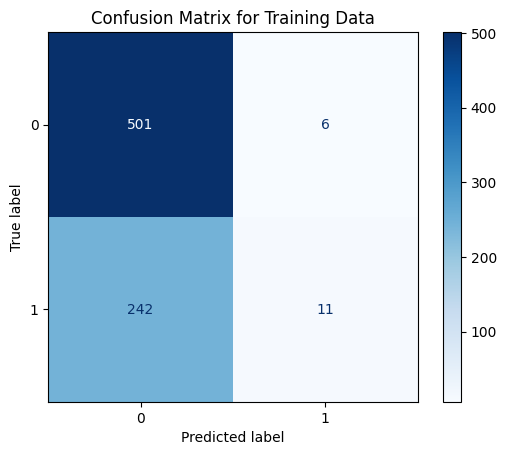

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_train, y_pred_train_binary)

# Step 4: Visualize or print the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Training Data")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_pred_train_binary))

              precision    recall  f1-score   support

           0       0.67      0.99      0.80       507
           1       0.65      0.04      0.08       253

    accuracy                           0.67       760
   macro avg       0.66      0.52      0.44       760
weighted avg       0.67      0.67      0.56       760



In [ ]:
y_pred_test = model.predict([spectrograms_test_breathing, spectrograms_test_coughing, spectrograms_test_speech, other_features_test])

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 277ms/step


In [ ]:
y_pred_test_binary = (y_pred_test > 0.6).astype(int)

In [ ]:
cm = confusion_matrix(y_test, y_pred_test_binary)

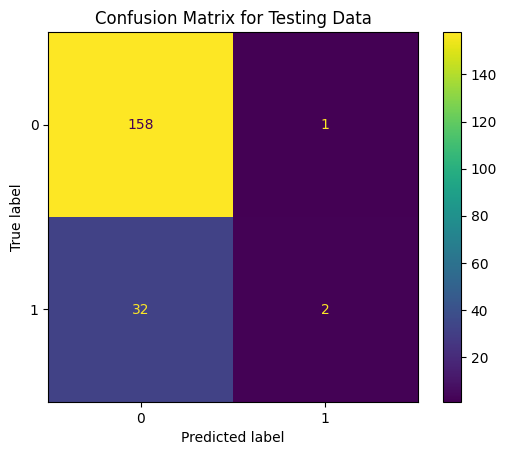

In [ ]:
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.title("Confusion Matrix for Testing Data")
plt.show()

In [ ]:
accuracy_test = accuracy_score(y_test, y_pred_test_binary)
accuracy_test

0.7823834196891192

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_test_binary))

              precision    recall  f1-score   support

           0       0.83      0.99      0.91       159
           1       0.67      0.06      0.11        34

    accuracy                           0.83       193
   macro avg       0.75      0.53      0.51       193
weighted avg       0.80      0.83      0.76       193



In [ ]:
from sklearn.metrics import f1_score

weighted_f1 = f1_score(y_test, y_pred_test_binary, average='weighted')
print(f"Weighted F1 Score: {weighted_f1}")

Weighted F1 Score: 0.7738685534941594


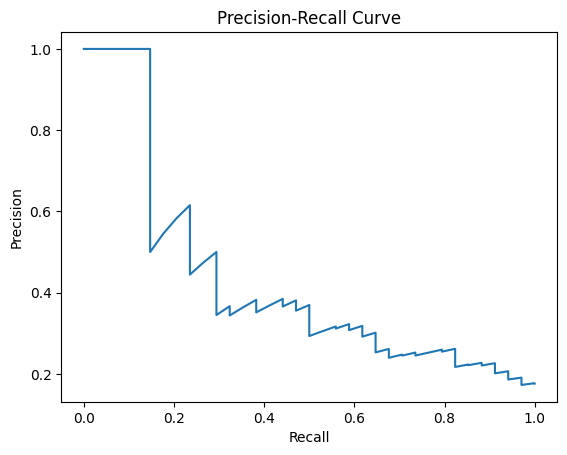

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_test)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

## Using Class Weights

- Doesn't categorize '1's correctly

In [ ]:
# Constants for updated time frames
num_mel_bands = 128
original_time_frames_breathing = 626 # prev: 622
original_time_frames_coughing = 751 # prev: 747
original_time_frames_speech = 1251 # prev: 1247

# Total original time frames
original_total_time_frames = original_time_frames_breathing + original_time_frames_coughing + original_time_frames_speech

# Total spectrogram features
total_padded_spectrogram_features = num_mel_bands * (max_time_frames * 3)

In [ ]:
# Separate resampled padded spectrograms and other features for X_train_resampled
padded_spectrograms_resampled = X_train[:, :total_padded_spectrogram_features]
other_features_resampled = X_train[:, total_padded_spectrogram_features:]

In [ ]:
padded_spectrograms_resampled.shape, other_features_resampled.shape

((772, 480384), (772, 6))

In [ ]:
# Verify actual size
print("Actual size of padded_spectrograms_resampled:", padded_spectrograms_resampled.size)

# Calculate expected size
expected_size = 716 * 128 * (max_time_frames * 3) * 1
print("Expected size for reshaping:", expected_size)

Actual size of padded_spectrograms_resampled: 370856448
Expected size for reshaping: 343954944


In [ ]:
padded_spectrograms_resampled_reshaped = padded_spectrograms_resampled.reshape(
    padded_spectrograms_resampled.shape[0], num_mel_bands,
    max_time_frames * 3, 1
)


In [ ]:
padded_spectrograms_resampled_reshaped.shape

(772, 128, 3753, 1)

In [ ]:
# Define a function to extract the original spectrograms without padding
def extract_original_spectrograms(padded_spectrograms, time_frames_breathing, time_frames_coughing, time_frames_speech):
    # Extract breathing spectrogram
    breathing = padded_spectrograms[:, :, :time_frames_breathing, :]
    
    # Extract coughing spectrogram
    coughing_start = time_frames_breathing
    coughing_end = time_frames_breathing + time_frames_coughing
    coughing = padded_spectrograms[:, :, coughing_start:coughing_end, :]
    
    # Extract speech spectrogram
    speech_start = coughing_end
    speech_end = speech_start + time_frames_speech
    speech = padded_spectrograms[:, :, speech_start:speech_end, :]
    
    return breathing, coughing, speech

# Extract the original spectrograms from the padded data
spectrograms_train_breathing, spectrograms_train_coughing, spectrograms_train_speech = extract_original_spectrograms(
    padded_spectrograms_resampled_reshaped,
    original_time_frames_breathing,
    original_time_frames_coughing,
    original_time_frames_speech
)

In [ ]:
# Verify the shapes of the extracted spectrograms
print("Breathing Spectrogram Shape:", spectrograms_train_breathing.shape)  # Expected: (num_samples, 128, 622, 1)
print("Coughing Spectrogram Shape:", spectrograms_train_coughing.shape)   # Expected: (num_samples, 128, 747, 1)
print("Speech Spectrogram Shape:", spectrograms_train_speech.shape)       # Expected: (num_samples, 128, 1247, 1)

Breathing Spectrogram Shape: (772, 128, 626, 1)
Coughing Spectrogram Shape: (772, 128, 751, 1)
Speech Spectrogram Shape: (772, 128, 1251, 1)


In [ ]:
# For X_test (no resampling needed), separate and reshape the spectrograms
spectrograms_test = X_test[:, :total_padded_spectrogram_features]
other_features_test = X_test[:, total_padded_spectrogram_features:]

In [ ]:
spectrograms_test.shape, other_features_test.shape

((193, 480384), (193, 6))

In [ ]:
spectrograms_test_reshaped = spectrograms_test.reshape(
    spectrograms_test.shape[0], num_mel_bands, max_time_frames * 3, 1
)

In [ ]:
spectrograms_test_breathing, spectrograms_test_coughing, spectrograms_test_speech = extract_original_spectrograms(
    spectrograms_test_reshaped,
    original_time_frames_breathing,
    original_time_frames_coughing,
    original_time_frames_speech
)
# Verify shapes
print("Breathing Spectrogram Shape:", spectrograms_test_breathing.shape)
print("Coughing Spectrogram Shape:", spectrograms_test_coughing.shape)
print("Speech Spectrogram Shape:", spectrograms_test_speech.shape)


Breathing Spectrogram Shape: (193, 128, 626, 1)
Coughing Spectrogram Shape: (193, 128, 751, 1)
Speech Spectrogram Shape: (193, 128, 1251, 1)


In [ ]:
#convert y_train_resampled and y_test to numpy arrays

y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Concatenate, Dropout

# Define input for Mel spectrogram (shape: 625 time frames x 128 frequency bins x 1 channel)
mel_input_breathing = Input(shape=(128, 626, 1), name='mel_spectrogram_breathing')
mel_input_cough = Input(shape=(128, 751, 1), name='mel_spectrogram_cough')
mel_input_speech = Input(shape=(128, 1251, 1), name='mel_spectrogram_speech')


# Define CNN sub-network for Mel spectrogram
def create_cnn_subnetwork(input_layer):
    x = Conv2D(16, (3,3), activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(16, (3,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(32, (3,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = GlobalAveragePooling2D()(x)

    return x

# Create CNN sub-networks for each spectrogram input
cnn_breathing_output = create_cnn_subnetwork(mel_input_breathing)
cnn_cough_output = create_cnn_subnetwork(mel_input_cough)
cnn_speech_output = create_cnn_subnetwork(mel_input_speech)

# Define input for other features (zero-crossing rate and spectral centroid)
other_input = Input(shape=(6,), name='other_features')

# Define a simple dense sub-network for other features
y = Dense(64, activation='relu')(other_input)
y = Dense(128, activation='relu')(y)  # Add more dense layers
y = Dropout(0.3)(y)                   # Add dropout to prevent overfitting
y = Dense(128, activation='relu')(y)   # Another dense layer
y = Dense(64, activation='relu')(y)    # Another dense layer

# Concatenate both sub-networks
combined = Concatenate()([cnn_breathing_output, cnn_cough_output, cnn_speech_output, y])

# Add final classification layers
z = Dense(128, activation='relu')(combined)
z = Dropout(0.3)(z)                    # Add dropout to prevent overfitting
z = Dense(64, activation='relu')(z)
z = Dense(1, activation='sigmoid')(z)  # Binary classification

In [ ]:
# Define the model with two inputs
model = tf.keras.Model(inputs=[mel_input_breathing, mel_input_cough, mel_input_speech, other_input], outputs=z)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','recall','precision'])

# Print model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mel_spectrogram_br… │ (None, 128, 626,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mel_spectrogram_co… │ (None, 128, 751,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mel_spectrogram_sp… │ (None, 128, 1251, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 126, 624,  │        160 │ mel_spectrogram_… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 126, 749,  │        160 │ mel_spectrogram_… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 126, 1249, │        160 │ mel_spectrogram_… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 63, 312,   │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 63, 374,   │          0 │ conv2d_28[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 63, 624,   │          0 │ conv2d_32[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 61, 310,   │      2,320 │ max_pooling2d_24… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 61, 372,   │      2,320 │ max_pooling2d_28… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 61, 622,   │      2,320 │ max_pooling2d_32… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 30, 155,   │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 30, 186,   │          0 │ conv2d_29[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_33    │ (None, 30, 311,   │          0 │ conv2d_33[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ other_features      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 28, 153,   │      4,640 │ max_pooling2d_25

 Total params: 151,601 (592.19 KB)

 Trainable params: 151,601 (592.19 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train_breathing, X_val_breathing, \
X_train_coughing, X_val_coughing, \
X_train_speech, X_val_speech, \
X_train_other_features, X_val_other_features, \
y_train, y_val = train_test_split(
    spectrograms_train_breathing,
    spectrograms_train_coughing,
    spectrograms_train_speech,
    other_features_resampled,
    y_train,
    test_size=0.2,
    random_state=seed,
    stratify=y_train
)

# Step 2: Verify shapes of training and validation sets
print("Training set shapes:")
print("Breathing:", X_train_breathing.shape)
print("Coughing:", X_train_coughing.shape)
print("Speech:", X_train_speech.shape)
print("Other Features:", X_train_other_features.shape)
print("Labels:", y_train.shape)

print("\nValidation set shapes:")
print("Breathing:", X_val_breathing.shape)
print("Coughing:", X_val_coughing.shape)
print("Speech:", X_val_speech.shape)
print("Other Features:", X_val_other_features.shape)
print("Labels:", y_val.shape)


Training set shapes:
Breathing: (617, 128, 626, 1)
Coughing: (617, 128, 751, 1)
Speech: (617, 128, 1251, 1)
Other Features: (617, 6)
Labels: (617,)

Validation set shapes:
Breathing: (155, 128, 626, 1)
Coughing: (155, 128, 751, 1)
Speech: (155, 128, 1251, 1)
Other Features: (155, 6)
Labels: (155,)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Metric to monitor (e.g., validation loss)
    patience=5,                 # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore the weights of the best epoch
    verbose=1                   # Print messages when early stopping is triggered
)

history = model.fit(
    [X_train_breathing, X_train_coughing, X_train_speech, X_train_other_features],
    y_train,
    validation_data=(
        [X_val_breathing, X_val_coughing, X_val_speech, X_val_other_features],
        y_val
    ),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    class_weight=dict(enumerate(class_weights))
)


# Step 4: Evaluate the model on the validation set
results = model.evaluate(
    [X_val_breathing, X_val_coughing, X_val_speech, X_val_other_features],
    y_val
)

# Print all evaluation metrics
for metric_name, metric_value in zip(model.metrics_names, results):
    print(f"{metric_name}: {metric_value}")

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4916 - loss: 11.1316 - precision: 0.1816 - recall: 0.4538 - val_accuracy: 0.6194 - val_loss: 1.0005 - val_precision: 0.1961 - val_recall: 0.3571
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.5173 - loss: 5.3053 - precision: 0.2067 - recall: 0.5093 - val_accuracy: 0.1935 - val_loss: 1.7798 - val_precision: 0.1830 - val_recall: 1.0000
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5203 - loss: 3.4475 - precision: 0.1966 - recall: 0.4604 - val_accuracy: 0.7871 - val_loss: 0.5310 - val_precision: 0.2727 - val_recall: 0.1071
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5112 - loss: 2.5075 - precision: 0.1854 - recall: 0.4364 - val_accuracy: 0.2000 - val_loss: 1.1630 - val_precision: 0.1757 - val_recall: 0.9286
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5223 - loss: 1.3940 - precision: 0.2222 - recall: 0.5717 - val_accuracy: 0.8065 - val_loss: 0.5405 - va

In [ ]:
y_pred_train = model.predict([X_train_breathing, X_train_coughing, X_train_speech, X_train_other_features])

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 304ms/step


In [ ]:
y_pred_train_binary = (y_pred_train > 0.6).astype(int)

In [ ]:
y_train.shape, y_pred_train_binary.shape

((617,), (617, 1))

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train_binary)

print(f"Training Accuracy: {accuracy_train}")

Training Accuracy: 0.8233387358184765


In [ ]:
accuracy_train

0.8233387358184765

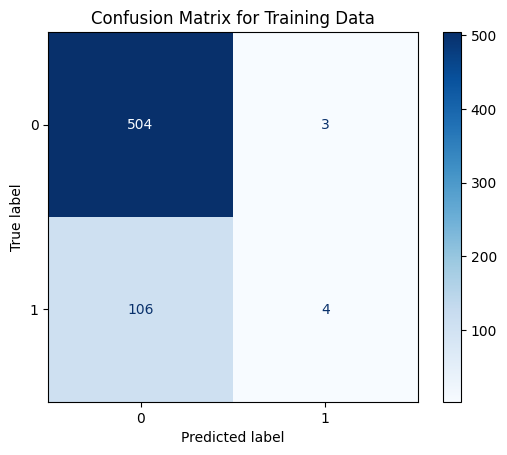

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_train, y_pred_train_binary)

# Step 4: Visualize or print the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Training Data")
plt.show()

In [ ]:
y_pred_test = model.predict([spectrograms_test_breathing, spectrograms_test_coughing, spectrograms_test_speech, other_features_test])

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step


In [ ]:
y_pred_test_binary = (y_pred_test > 0.6).astype(int)

In [ ]:
cm = confusion_matrix(y_test, y_pred_test_binary)

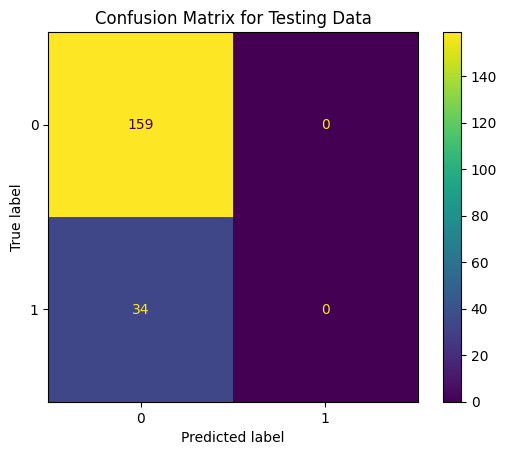

In [ ]:
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.title("Confusion Matrix for Testing Data")
plt.show()

In [ ]:
accuracy_test = accuracy_score(y_test, y_pred_test_binary)
accuracy_test

0.8238341968911918

## SMOTETomek
- Doesn't categorize '1's correctly

In [ ]:
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(smote=smote, random_state=seed)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

In [ ]:
# Print resampled class distribution
print(f"Original class distribution: {Counter(y_train)}")
print(f"Resampled class distribution: {Counter(y_train_resampled)}")

Original class distribution: Counter({np.int64(0): 634, np.int64(1): 138})
Resampled class distribution: Counter({np.int64(0): 629, np.int64(1): 312})


In [ ]:
# Constants for updated time frames
num_mel_bands = 128
original_time_frames_breathing = 626 # prev: 622
original_time_frames_coughing = 751 # prev: 747
original_time_frames_speech = 1251 # prev: 1247

# Total original time frames
original_total_time_frames = original_time_frames_breathing + original_time_frames_coughing + original_time_frames_speech

# Total spectrogram features
total_padded_spectrogram_features = num_mel_bands * (max_time_frames * 3)

In [ ]:
# Separate resampled padded spectrograms and other features for X_train_resampled
padded_spectrograms_resampled = X_train_resampled[:, :total_padded_spectrogram_features]
other_features_resampled = X_train_resampled[:, total_padded_spectrogram_features:]

In [ ]:
padded_spectrograms_resampled_reshaped = padded_spectrograms_resampled.reshape(
    padded_spectrograms_resampled.shape[0], num_mel_bands,
    max_time_frames * 3, 1
)

In [ ]:
# Define a function to extract the original spectrograms without padding
def extract_original_spectrograms(padded_spectrograms, time_frames_breathing, time_frames_coughing, time_frames_speech):
    # Extract breathing spectrogram
    breathing = padded_spectrograms[:, :, :time_frames_breathing, :]
    
    # Extract coughing spectrogram
    coughing_start = time_frames_breathing
    coughing_end = time_frames_breathing + time_frames_coughing
    coughing = padded_spectrograms[:, :, coughing_start:coughing_end, :]
    
    # Extract speech spectrogram
    speech_start = coughing_end
    speech_end = speech_start + time_frames_speech
    speech = padded_spectrograms[:, :, speech_start:speech_end, :]
    
    return breathing, coughing, speech

# Extract the original spectrograms from the padded data
spectrograms_train_breathing, spectrograms_train_coughing, spectrograms_train_speech = extract_original_spectrograms(
    padded_spectrograms_resampled_reshaped,
    original_time_frames_breathing,
    original_time_frames_coughing,
    original_time_frames_speech
)

In [ ]:
# Verify the shapes of the extracted spectrograms
print("Breathing Spectrogram Shape:", spectrograms_train_breathing.shape)  # Expected: (num_samples, 128, 622, 1)
print("Coughing Spectrogram Shape:", spectrograms_train_coughing.shape)   # Expected: (num_samples, 128, 747, 1)
print("Speech Spectrogram Shape:", spectrograms_train_speech.shape)       # Expected: (num_samples, 128, 1247, 1)

Breathing Spectrogram Shape: (941, 128, 626, 1)
Coughing Spectrogram Shape: (941, 128, 751, 1)
Speech Spectrogram Shape: (941, 128, 1251, 1)


In [ ]:
# For X_test (no resampling needed), separate and reshape the spectrograms
spectrograms_test = X_test[:, :total_padded_spectrogram_features]
other_features_test = X_test[:, total_padded_spectrogram_features:]

In [ ]:
spectrograms_test.shape, other_features_test.shape

((193, 480384), (193, 6))

In [ ]:
spectrograms_test_reshaped = spectrograms_test.reshape(
    spectrograms_test.shape[0], num_mel_bands, max_time_frames * 3, 1
)

In [ ]:
# Separate spectrogram_test_reshaped into breathing, coughing, and speech
# spectrograms_test_breathing_resampled = spectrograms_test_reshaped[:, :, :num_time_frames, :]
# spectrograms_test_coughing_resampled = spectrograms_test_reshaped[:, :, num_time_frames:num_time_frames*2, :]
# spectrograms_test_speech_resampled = spectrograms_test_reshaped[:, :, num_time_frames*2:, :]

spectrograms_test_breathing, spectrograms_test_coughing, spectrograms_test_speech = extract_original_spectrograms(
    spectrograms_test_reshaped,
    original_time_frames_breathing,
    original_time_frames_coughing,
    original_time_frames_speech
)
# Verify shapes
print("Breathing Spectrogram Shape:", spectrograms_test_breathing.shape)
print("Coughing Spectrogram Shape:", spectrograms_test_coughing.shape)
print("Speech Spectrogram Shape:", spectrograms_test_speech.shape)


Breathing Spectrogram Shape: (193, 128, 626, 1)
Coughing Spectrogram Shape: (193, 128, 751, 1)
Speech Spectrogram Shape: (193, 128, 1251, 1)


In [ ]:
#convert y_train_resampled and y_test to numpy arrays

y_train_resampled = np.array(y_train_resampled)
y_test = np.array(y_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Concatenate, Dropout

# Define input for Mel spectrogram (shape: 625 time frames x 128 frequency bins x 1 channel)
mel_input_breathing = Input(shape=(128, 626, 1), name='mel_spectrogram_breathing')
mel_input_cough = Input(shape=(128, 751, 1), name='mel_spectrogram_cough')
mel_input_speech = Input(shape=(128, 1251, 1), name='mel_spectrogram_speech')


# Define CNN sub-network for Mel spectrogram
def create_cnn_subnetwork(input_layer):
    x = Conv2D(16, (3,3), activation='relu')(input_layer)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(16, (3,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(32, (3,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = GlobalAveragePooling2D()(x)

    return x

# Create CNN sub-networks for each spectrogram input
cnn_breathing_output = create_cnn_subnetwork(mel_input_breathing)
cnn_cough_output = create_cnn_subnetwork(mel_input_cough)
cnn_speech_output = create_cnn_subnetwork(mel_input_speech)

# Define input for other features (zero-crossing rate and spectral centroid)
other_input = Input(shape=(6,), name='other_features')

# Define a simple dense sub-network for other features
y = Dense(64, activation='relu')(other_input)
y = Dense(128, activation='relu')(y)  # Add more dense layers
y = Dropout(0.3)(y)                   # Add dropout to prevent overfitting
y = Dense(128, activation='relu')(y)   # Another dense layer
y = Dense(64, activation='relu')(y)    # Another dense layer

# Concatenate both sub-networks
combined = Concatenate()([cnn_breathing_output, cnn_cough_output, cnn_speech_output, y])

# Add final classification layers
z = Dense(128, activation='relu')(combined)
z = Dropout(0.3)(z)                    # Add dropout to prevent overfitting
z = Dense(64, activation='relu')(z)
z = Dense(1, activation='sigmoid')(z)  # Binary classification

In [ ]:
# Define the model with two inputs
model = tf.keras.Model(inputs=[mel_input_breathing, mel_input_cough, mel_input_speech, other_input], outputs=z)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','recall','precision'])

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mel_spectrogram_br… │ (None, 128, 626,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mel_spectrogram_co… │ (None, 128, 751,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mel_spectrogram_sp… │ (None, 128, 1251, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 624,  │        160 │ mel_spectrogram_… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 126, 749,  │        160 │ mel_spectrogram_… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 126, 1249, │        160 │ mel_spectrogram_… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 312,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 63, 374,   │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 63, 624,   │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 310,   │      2,320 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 61, 372,   │      2,320 │ max_pooling2d_4[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 61, 622,   │      2,320 │ max_pooling2d_8[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 155,   │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 30, 186,   │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 30, 311,   │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ other_features      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 153,   │      4,640 │ max_pooling2d_1[

 Total params: 151,601 (592.19 KB)

 Trainable params: 151,601 (592.19 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train_breathing, X_val_breathing, \
X_train_coughing, X_val_coughing, \
X_train_speech, X_val_speech, \
X_train_other_features, X_val_other_features, \
y_train_tomek, y_val_tomek = train_test_split(
    spectrograms_train_breathing,
    spectrograms_train_coughing,
    spectrograms_train_speech,
    other_features_resampled,
    y_train_resampled,
    test_size=0.2,
    random_state=seed,
    stratify=y_train_resampled
)

# Step 2: Verify shapes of training and validation sets
print("Training set shapes:")
print("Breathing:", X_train_breathing.shape)
print("Coughing:", X_train_coughing.shape)
print("Speech:", X_train_speech.shape)
print("Other Features:", X_train_other_features.shape)
print("Labels:", y_train_tomek.shape)

print("\nValidation set shapes:")
print("Breathing:", X_val_breathing.shape)
print("Coughing:", X_val_coughing.shape)
print("Speech:", X_val_speech.shape)
print("Other Features:", X_val_other_features.shape)
print("Labels:", y_val_tomek.shape)


Training set shapes:
Breathing: (752, 128, 626, 1)
Coughing: (752, 128, 751, 1)
Speech: (752, 128, 1251, 1)
Other Features: (752, 6)
Labels: (752,)

Validation set shapes:
Breathing: (189, 128, 626, 1)
Coughing: (189, 128, 751, 1)
Speech: (189, 128, 1251, 1)
Other Features: (189, 6)
Labels: (189,)


### Check Sub-Model Performance

In [ ]:
from tensorflow.keras.layers import BatchNormalization

def create_cnn_subnetwork_batch_normalization(input_layer):
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)  # Add batch normalization
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)  # Add batch normalization
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)  # Add batch normalization
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = GlobalAveragePooling2D()(x)

    return x

In [ ]:
X_train_breathing_subset, l, y_train_breathing_subset, k = train_test_split(X_train_breathing, y_train_tomek, test_size = 0.9, random_state = seed, stratify = y_train_tomek)
X_train_breathing_subset, X_val_breathing_subset, y_train_breathing_subset, y_val_breathing_subset = train_test_split(X_train_breathing_subset, y_train_breathing_subset, test_size = 0.1, random_state = seed, stratify = y_train_breathing_subset)

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

# Define a simple CNN model for testing
breathing_layer = Input(shape=(128, 626, 1))
breathing_output = create_cnn_subnetwork_batch_normalization(breathing_layer)

# Add a dense classifier on top of the CNN subnetwork
classifier_output = Dense(1, activation='sigmoid')(breathing_output)

# Create and compile the model
test_model = Model(inputs=breathing_layer, outputs=classifier_output)
test_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train on a small dataset (replace with actual data)
history = test_model.fit(X_train_breathing_subset, y_train_breathing_subset,
                         validation_data=(X_val_breathing_subset, y_val_breathing_subset),
                         epochs=10,
                         batch_size=32)

# Evaluate performance
train_loss, train_accuracy = test_model.evaluate(X_train_breathing_subset, y_train_breathing_subset)
print(f"train Accuracy: {train_accuracy}")

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6224 - loss: 0.6832 - val_accuracy: 0.6250 - val_loss: 0.6684
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7215 - loss: 0.5728 - val_accuracy: 0.6250 - val_loss: 0.6612
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7712 - loss: 0.4939 - val_accuracy: 0.6250 - val_loss: 0.6572
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7712 - loss: 0.4759 - val_accuracy: 0.6250 - val_loss: 0.6533
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7826 - loss: 0.4320 - val_accuracy: 0.6250 - val_loss: 0.6533
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8551 - loss: 0.4057 - val_accuracy: 0.6250 - val_loss: 0.6567
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8359 - loss: 0.3943 - val_accuracy: 0.6250 - val_loss: 0.6621
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8551 - loss: 0.3784 - val_accuracy: 0.6250 - val_loss: 0.6677
Epoch 9/10
3/3 ━

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


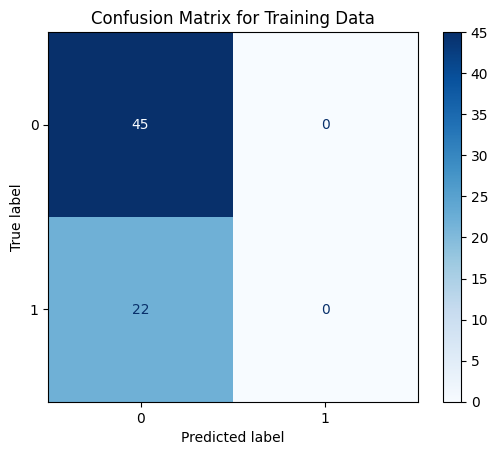

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_train_subset = test_model.predict(X_train_breathing_subset)
y_pred_train_subset_binary = (y_pred_train_subset > 0.6).astype(int)

cm = confusion_matrix(y_train_breathing_subset, y_pred_train_subset_binary)

# Step 4: Visualize or print the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Training Data")
plt.show()

### Main Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Metric to monitor (e.g., validation loss)
    patience=5,                 # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore the weights of the best epoch
    verbose=1                   # Print messages when early stopping is triggered
)

history = model.fit(
    [X_train_breathing, X_train_coughing, X_train_speech, X_train_other_features],
    y_train_tomek,
    validation_data=(
        [X_val_breathing, X_val_coughing, X_val_speech, X_val_other_features],
        y_val_tomek
    ),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)


# Step 4: Evaluate the model on the validation set
results = model.evaluate(
    [X_val_breathing, X_val_coughing, X_val_speech, X_val_other_features],
    y_val_tomek
)

Epoch 1/50


/Users/opheliasin/covid-detection/venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['mel_spectrogram_breathing', 'mel_spectrogram_cough', 'mel_spectrogram_speech', 'other_features']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5960 - loss: 8.8950 - precision: 0.3570 - recall: 0.3418 - val_accuracy: 0.6296 - val_loss: 1.4145 - val_precision: 0.2941 - val_recall: 0.0794
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5437 - loss: 2.2860 - precision: 0.3219 - recall: 0.3642 - val_accuracy: 0.6296 - val_loss: 0.7797 - val_precision: 0.3158 - val_recall: 0.0952
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.5703 - loss: 1.4029 - precision: 0.3331 - recall: 0.3117 - val_accuracy: 0.6402 - val_loss: 0.7117 - val_precision: 0.3333 - val_recall: 0.0794
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5634 - loss: 1.0284 - precision: 0.3238 - recall: 0.3081 - val_accuracy: 0.6561 - val_loss: 0.6627 - val_precision: 0.3333 - val_recall: 0.0317
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5955 - loss: 0.8170 - precision: 0.3688 - recall: 0.3409 - val_accuracy: 0.6878 - val_loss: 0.6463 - val_precision:

In [ ]:
y_pred_train_tomek = model.predict([X_train_breathing, X_train_coughing, X_train_speech, X_train_other_features])

/Users/opheliasin/covid-detection/venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['mel_spectrogram_breathing', 'mel_spectrogram_cough', 'mel_spectrogram_speech', 'other_features']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 551ms/step


In [ ]:
y_pred_train_tomek_binary = (y_pred_train_tomek > 0.6).astype(int)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_train_tomek, y_pred_train_tomek_binary))

              precision    recall  f1-score   support

           0       0.68      0.99      0.80       503
           1       0.69      0.04      0.07       249

    accuracy                           0.68       752
   macro avg       0.68      0.51      0.44       752
weighted avg       0.68      0.68      0.56       752



In [ ]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train_tomek, y_pred_train_tomek_binary)

print(f"Training Accuracy: {accuracy_train}")

Training Accuracy: 0.675531914893617


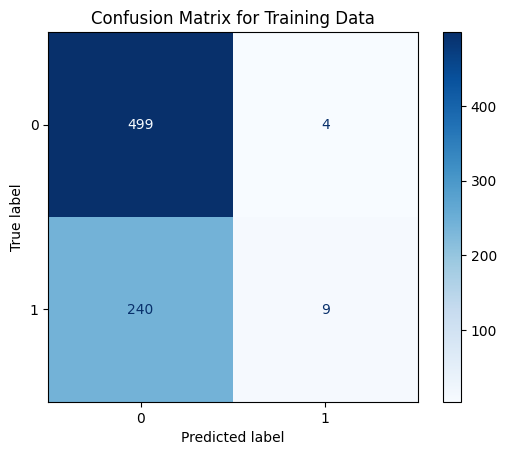

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_train_tomek, y_pred_train_tomek_binary)

# Step 4: Visualize or print the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Training Data")
plt.show()

In [ ]:
y_pred_test = model.predict([spectrograms_test_breathing, spectrograms_test_coughing, spectrograms_test_speech, other_features_test])

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step


In [ ]:
y_pred_test_binary = (y_pred_test > 0.6).astype(int)

In [ ]:
cm = confusion_matrix(y_test, y_pred_test_binary)

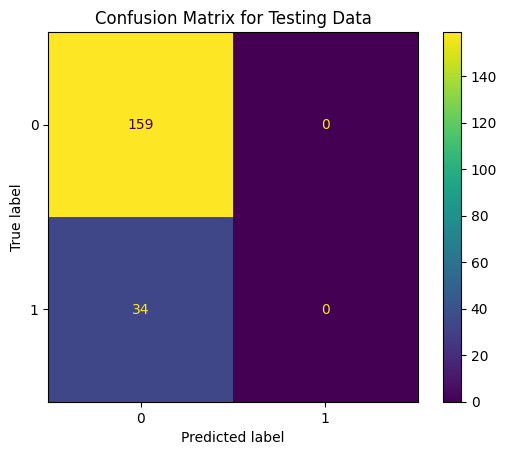

In [ ]:
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.title("Confusion Matrix for Testing Data")
plt.show()

In [ ]:
from sklearn.metrics import balanced_accuracy_score

balanced_acc = balanced_accuracy_score(y_test, y_pred_test_binary)
print(f"Balanced Accuracy: {balanced_acc}")

Balanced Accuracy: 0.5


## Focal Loss
- categorized all 1s as 0s

In [ ]:
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return -tf.reduce_mean(alpha * tf.pow(1. - pt, gamma) * tf.math.log(pt))
    return loss

In [ ]:
# Define the model with two inputs
model = tf.keras.Model(inputs=[mel_input_breathing, mel_input_cough, mel_input_speech, other_input], outputs=z)

# Compile the model
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy', 'recall', 'precision'])

# Print model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mel_spectrogram_br… │ (None, 128, 626,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mel_spectrogram_co… │ (None, 128, 751,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mel_spectrogram_sp… │ (None, 128, 1251, │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 126, 624,  │        160 │ mel_spectrogram_… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 126, 749,  │        160 │ mel_spectrogram_… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 126, 1249, │        160 │ mel_spectrogram_… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 63, 312,   │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_28    │ (None, 63, 374,   │          0 │ conv2d_28[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 63, 624,   │          0 │ conv2d_32[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 61, 310,   │      2,320 │ max_pooling2d_24… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 61, 372,   │      2,320 │ max_pooling2d_28… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 61, 622,   │      2,320 │ max_pooling2d_32… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 30, 155,   │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_29    │ (None, 30, 186,   │          0 │ conv2d_29[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_33    │ (None, 30, 311,   │          0 │ conv2d_33[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ other_features      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 28, 153,   │      4,640 │ max_pooling2d_25

 Total params: 151,601 (592.19 KB)

 Trainable params: 151,601 (592.19 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Metric to monitor (e.g., validation loss)
    patience=5,                 # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore the weights of the best epoch
    verbose=1                   # Print messages when early stopping is triggered
)

history = model.fit(
    [X_train_breathing, X_train_coughing, X_train_speech, X_train_other_features],
    y_train,
    validation_data=(
        [X_val_breathing, X_val_coughing, X_val_speech, X_val_other_features],
        y_val
    ),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]
)


# Step 4: Evaluate the model on the validation set
results = model.evaluate(
    [X_val_breathing, X_val_coughing, X_val_speech, X_val_other_features],
    y_val
)

Epoch 1/50


/Users/opheliasin/covid-detection/venv/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['mel_spectrogram_breathing', 'mel_spectrogram_cough', 'mel_spectrogram_speech', 'other_features']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6757 - loss: 0.0951 - precision: 0.1698 - recall: 0.1723 - val_accuracy: 0.8194 - val_loss: 0.0306 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7207 - loss: 0.0419 - precision: 0.1768 - recall: 0.1152 - val_accuracy: 0.8194 - val_loss: 0.0307 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.7720 - loss: 0.0421 - precision: 0.1971 - recall: 0.0439 - val_accuracy: 0.8194 - val_loss: 0.0312 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.7760 - loss: 0.0389 - precision: 0.1449 - recall: 0.0279 - val_accuracy: 0.8194 - val_loss: 0.0302 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7971 - loss: 0.0342 - precision: 0.0995 - recall: 0.0093 - val_accuracy: 0.8194 - v

In [ ]:
y_pred_train = model.predict([X_train_breathing, X_train_coughing, X_train_speech, X_train_other_features])

20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 484ms/step


In [ ]:
y_pred_train_binary = (y_pred_train > 0.6).astype(int)

In [ ]:
y_train.shape, y_pred_train_binary.shape

((617,), (617, 1))

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_train = accuracy_score(y_train, y_pred_train_binary)

print(f"Training Accuracy: {accuracy_train}")

Training Accuracy: 0.8217179902755267


In [ ]:
accuracy_train

0.8217179902755267

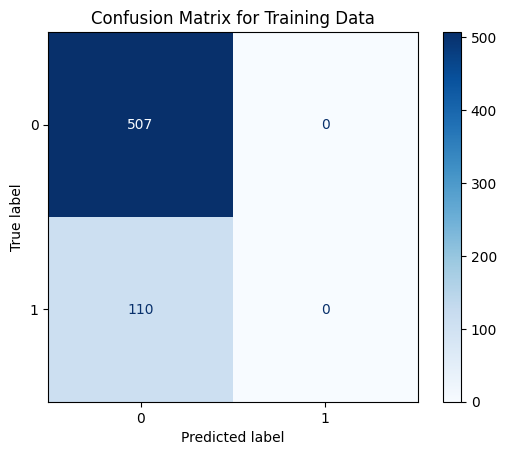

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_train, y_pred_train_binary)

# Step 4: Visualize or print the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Training Data")
plt.show()

In [ ]:
y_pred_test = model.predict([spectrograms_test_breathing, spectrograms_test_coughing, spectrograms_test_speech, other_features_test])

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 283ms/step


In [ ]:
y_pred_test_binary = (y_pred_test > 0.6).astype(int)

In [ ]:
cm = confusion_matrix(y_test, y_pred_test_binary)

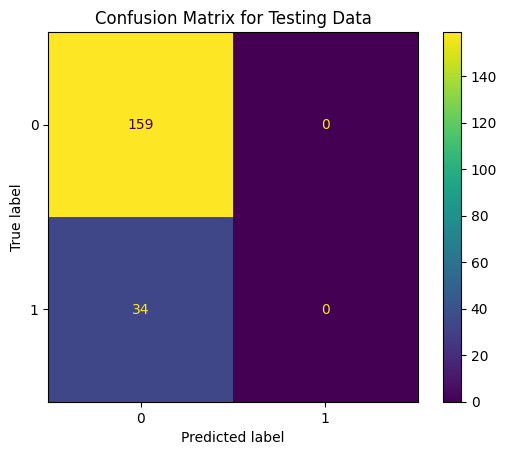

In [ ]:
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.title("Confusion Matrix for Testing Data")
plt.show()

In [ ]:
accuracy_test = accuracy_score(y_test, y_pred_test_binary)
accuracy_test

0.8238341968911918